In [1]:
# Hago los imports necesarios para el proyecto
import warnings
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from itertools import combinations
from statistics import mean, median, mode
from collections import Counter
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, jaccard_score

warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8')
%matplotlib inline

In [2]:
# Creo una funcion para ver la tasa de captura promedio de cada una de las clases de las columnas categoricas

def mean_by_class(data:pd.DataFrame, column1:str, col_objetivo:str):
    
    df = pd.DataFrame(data[[column1, col_objetivo]].groupby(column1 , as_index=False).mean().sort_values(by=col_objetivo, ascending=False))
    df.reset_index(drop=True, inplace=True)
    
    x = df[column1].tolist()
    y = df[col_objetivo].tolist()
    
    plt.rcParams['figure.figsize']=20,7
    sns.set_style('darkgrid')
    ax = sns.barplot(x=x, y=y, palette = "dark", saturation =2.0)
    
    plt.xlabel(f"{column1}", fontsize = 25 )
    plt.ylabel('Catch_Rate', fontsize = 20)
    plt.title(f"Catch_Rate de cada\n{column1}", fontsize = 20)
    plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 80)
    plt.yticks(fontsize = 12)
    
    for i in ax.patches:
        width, height = i.get_width(), i.get_height()
        x, y = i.get_xy() 
        ax.annotate(f'{round(height,2)}', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
    
    print(df)
    plt.show()

In [3]:
# Creo una funcion para ver el grado de correlacion entre las variables numericas y catch_rate

def pr_correlation(df:pd.DataFrame):
    
    num_df = df.select_dtypes(include=['number'])
    
    sns.set(font_scale=1.75)
    sns.pairplot(num_df, height=3)
    
    plt.suptitle('Matriz de dispersión', y=1.02, fontsize=6)
    plt.show()
    
    corr_matrix = num_df.corr()
    print("Matriz de correlaciones:")
    print(corr_matrix)
    
    sns.set(font_scale=1.2)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    
    plt.title('Heatmap de Correlaciones')
    plt.show()

In [4]:
# Creo esta funcion para realizar la prueba cramer's v para saber el grado 
# de dependencia entre las variables categoricas

def cramers_v(chi2, contingency_table):
    n = contingency_table.sum().sum()  
    min_dim = min(contingency_table.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

In [5]:
# Creo una funcion para mapear las variables categoricas
def mapear(data, columns):
    for column in columns:
        
        maping = {}
        
        if type(data[column][0]) == str:
            
            options = data[column].drop_duplicates().tolist()
            
            for index, element in enumerate(options):
                
                maping[element] = index+1
            
            data[column] = data[column].map(maping).astype(int)

In [6]:
# Creo una funcion para probar las multiples opciones de modelos que he escogido
def test_models(x_train, y_train, x_test, y_test):
        
        warnings.filterwarnings("ignore")
        models = [LogisticRegression, RandomForestClassifier, ExtraTreesClassifier, BernoulliNB,
                  GaussianNB, DecisionTreeClassifier, ExtraTreeClassifier, KNeighborsClassifier,
                  LinearSVC, NuSVC, SVC]
        results = []
        
        for model in models:
            
            model = model() 
            model.fit(x_train, y_train)
            
            scores = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy')
            print(f'Modelo: {model} \n')
            print('-'*60, '\n')
            print(f'Cross-Validation')
            print(f'{scores.mean()}\n')
            
            predict = model.predict(x_test)
            print(f'Prediccion: \n{list(predict[:150])}\n')
            print('\/'*50, '\n')
            print(f'Valores Reales: \n{list(y_test[:150])}\n')
            
            accuracy = accuracy_score(y_test, predict)
            print(f'Accuracy:\n{accuracy}\n')
            
            if len(results) != 3:
                
                results.append({'Accuracy': round(accuracy, 3), 'Model': model})
            
            else:
                
                for dic in results:
                    
                    if dic['Accuracy'] < accuracy:
                        
                        dic['Accuracy'], dic['Model'] = round(accuracy, 3), model

            
            precision = precision_score(y_test, predict, average=None)
            print(f'Precision:\n{precision.mean()}\n')
            
            recall = recall_score(y_test, predict, average=None)
            print(f'Recall:\n{recall.mean()}\n')
            
            f1 = f1_score(y_test, predict, average=None)
            print(f'F1:\n{f1.mean()}\n')
            
            jaccard = jaccard_score(y_test, predict, average=None)
            print(f'Jaccard:\n{jaccard.mean()}\n')
            
            conf_matrix = confusion_matrix(y_test, predict) 
            print(f'Matriz de confusion:\n{conf_matrix}\n')
            
            vals = {'true': 0, 'false': 0}
            predict = list(predict)
            y_test = list(y_test)
            
            for pred, real in zip(predict, y_test):
                if pred == real:
                    vals['true'] += 1
                else:
                    vals['false'] += 1
            print(f'Predicciones correctas : {vals["true"]}\nPredicciones fallidas: {vals["false"]}\nPredicciones totales: {len(y_test)}\n')
            
            print('-'*60, '\n')
        
        print(f'Los 3 mejores modelos son: ')
        print(f'{sorted(results, key=lambda x: list(x.values())[0], reverse=True)}')

### Importo el dataset

In [7]:
data_pokemons = pd.read_csv('pokemon_alopez247.csv')
data_pokemons


Number        Name   Type_1  Type_2  Total   HP  Attack  Defense  Sp_Atk  \
0         1   Bulbasaur    Grass  Poison    318   45      49       49      65   
1         2     Ivysaur    Grass  Poison    405   60      62       63      80   
2         3    Venusaur    Grass  Poison    525   80      82       83     100   
3         4  Charmander     Fire     NaN    309   39      52       43      60   
4         5  Charmeleon     Fire     NaN    405   58      64       58      80   
..      ...         ...      ...     ...    ...  ...     ...      ...     ...   
716     717     Yveltal     Dark  Flying    680  126     131       95     131   
717     718     Zygarde   Dragon  Ground    600  108     100      121      81   
718     719     Diancie     Rock   Fairy    600   50     100      150     100   
719     720       Hoopa  Psychic   Ghost    600   80     110       60     150   
720     721   Volcanion     Fire   Water    600   80     110      120     130   

     Sp_Def  ...   Color  hasGender  Pr_Male   Egg_Group_1  Egg_Group_2  \
0        65  ...   Green       True    0.875       Monster        Grass   
1        80  ...   Green       True    0.875       Monster        Grass   
2       100  ...   Green       True    0.875       Monster        Grass   
3        50  ...     Red       True    0.875       Monster       Dragon   
4        65  ...     Red       True    0.875       Monster       Dragon   
..      ...  ...     ...        ...      ...           ...          ...   
716      98  ...     Red      False      NaN  Undiscovered          NaN   
717      95  ...   Green      False      NaN  Undiscovered          NaN   
718     150  ...    Pink      False      NaN  Undiscovered          NaN   
719     130  ...  Purple      False      NaN  Undiscovered          NaN   
720      90  ...   Brown      False      NaN  Undiscovered          NaN   

     hasMegaEvolution Height_m Weight_kg  Catch_Rate       Body_Style  
0               False     0.71       6.9          45        quadruped  
1               False     0.99      13.0          45        quadruped  
2                True     2.01     100.0          45        quadruped  
3               False     0.61       8.5          45   bipedal_tailed  
4               False     1.09      19.0          45   bipedal_tailed  
..                ...      ...       ...         ...              ...  
716             False     5.79     203.0          45        two_wings  
717             False     5.00     305.0           3  serpentine_body  
718              True     0.71       8.8           3        head_arms  
719             False     0.51       9.0           3        head_only  
720             False     1.70     195.0           3        quadruped  

[721 rows x 23 columns]

### Hago una copia del dataset para trabajar con ella en vez de con el original

In [8]:
copy_pokemons = data_pokemons.copy()

### Veo de manera rapida la informacion de la tabla


In [9]:
copy_pokemons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721 entries, 0 to 720
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Number            721 non-null    int64  
 1   Name              721 non-null    object 
 2   Type_1            721 non-null    object 
 3   Type_2            350 non-null    object 
 4   Total             721 non-null    int64  
 5   HP                721 non-null    int64  
 6   Attack            721 non-null    int64  
 7   Defense           721 non-null    int64  
 8   Sp_Atk            721 non-null    int64  
 9   Sp_Def            721 non-null    int64  
 10  Speed             721 non-null    int64  
 11  Generation        721 non-null    int64  
 12  isLegendary       721 non-null    bool   
 13  Color             721 non-null    object 
 14  hasGender         721 non-null    bool   
 15  Pr_Male           644 non-null    float64
 16  Egg_Group_1       721 non-null    object 
 1

### Hago un analisis rapido de las variables numericas


In [10]:
copy_pokemons.describe()

Number       Total          HP      Attack     Defense      Sp_Atk  \
count  721.00000  721.000000  721.000000  721.000000  721.000000  721.000000   
mean   361.00000  417.945908   68.380028   75.013870   70.808599   68.737864   
std    208.27906  109.663671   25.848272   28.984475   29.296558   28.788005   
min      1.00000  180.000000    1.000000    5.000000    5.000000   10.000000   
25%    181.00000  320.000000   50.000000   53.000000   50.000000   45.000000   
50%    361.00000  424.000000   65.000000   74.000000   65.000000   65.000000   
75%    541.00000  499.000000   80.000000   95.000000   85.000000   90.000000   
max    721.00000  720.000000  255.000000  165.000000  230.000000  154.000000   

           Sp_Def       Speed  Generation     Pr_Male    Height_m   Weight_kg  \
count  721.000000  721.000000  721.000000  644.000000  721.000000  721.000000   
mean    69.291262   65.714286    3.323162    0.553377    1.144979   56.773370   
std     27.015860   27.277920    1.669873    0.199969    1.044369   89.095667   
min     20.000000    5.000000    1.000000    0.000000    0.100000    0.100000   
25%     50.000000   45.000000    2.000000    0.500000    0.610000    9.400000   
50%     65.000000   65.000000    3.000000    0.500000    0.990000   28.000000   
75%     85.000000   85.000000    5.000000    0.500000    1.400000   61.000000   
max    230.000000  160.000000    6.000000    1.000000   14.500000  950.000000   

       Catch_Rate  
count  721.000000  
mean   100.246879  
std     76.573513  
min      3.000000  
25%     45.000000  
50%     65.000000  
75%    180.000000  
max    255.000000

### Lo mismo con las variables categoricas


In [11]:
copy_pokemons.describe(include='O')

Name Type_1  Type_2 Color Egg_Group_1 Egg_Group_2      Body_Style
count         721    721     350   721         721         191             721
unique        721     18      18    10          15          13              14
top     Bulbasaur  Water  Flying  Blue       Field      Dragon  bipedal_tailed
freq            1    105      87   134         169          35             158

### Observo las clases que hay dentro de cada caracteristica

In [12]:
for column in copy_pokemons.columns: 
    
    print(copy_pokemons[column].drop_duplicates())

0        1
1        2
2        3
3        4
4        5
      ... 
716    717
717    718
718    719
719    720
720    721
Name: Number, Length: 721, dtype: int64
0       Bulbasaur
1         Ivysaur
2        Venusaur
3      Charmander
4      Charmeleon
          ...    
716       Yveltal
717       Zygarde
718       Diancie
719         Hoopa
720     Volcanion
Name: Name, Length: 721, dtype: object
0         Grass
3          Fire
6         Water
9           Bug
15       Normal
22       Poison
24     Electric
26       Ground
34        Fairy
55     Fighting
62      Psychic
73         Rock
91        Ghost
123         Ice
146      Dragon
196        Dark
207       Steel
640      Flying
Name: Type_1, dtype: object
0        Poison
3           NaN
5        Flying
30       Ground
38        Fairy
45        Grass
61     Fighting
78      Psychic
80        Steel
86          Ice
110        Rock
137       Water
169    Electric
227        Fire
229      Dragon
247        Dark
291       Ghost
346         Bu

### Eliminamos las columnas Number y Name por no aportar ninguna informacion valiosa, y Type_2 y Egg_Group_2 por que tienen demasiados nulos. Ademas, relleno los valores NaN de la columna Pr_male con -1 porque indican aquellos pokemons que no tienen genero

In [13]:
copy_pokemons = copy_pokemons.drop(['Number', 'Name', 'Type_2', 'Egg_Group_2'], axis=1)
copy_pokemons['Pr_Male'] = copy_pokemons['Pr_Male'].fillna(-1)

copy_pokemons

Type_1  Total   HP  Attack  Defense  Sp_Atk  Sp_Def  Speed  Generation  \
0      Grass    318   45      49       49      65      65     45           1   
1      Grass    405   60      62       63      80      80     60           1   
2      Grass    525   80      82       83     100     100     80           1   
3       Fire    309   39      52       43      60      50     65           1   
4       Fire    405   58      64       58      80      65     80           1   
..       ...    ...  ...     ...      ...     ...     ...    ...         ...   
716     Dark    680  126     131       95     131      98     99           6   
717   Dragon    600  108     100      121      81      95     95           6   
718     Rock    600   50     100      150     100     150     50           6   
719  Psychic    600   80     110       60     150     130     70           6   
720     Fire    600   80     110      120     130      90     70           6   

     isLegendary   Color  hasGender  Pr_Male   Egg_Group_1  hasMegaEvolution  \
0          False   Green       True    0.875       Monster             False   
1          False   Green       True    0.875       Monster             False   
2          False   Green       True    0.875       Monster              True   
3          False     Red       True    0.875       Monster             False   
4          False     Red       True    0.875       Monster             False   
..           ...     ...        ...      ...           ...               ...   
716         True     Red      False   -1.000  Undiscovered             False   
717         True   Green      False   -1.000  Undiscovered             False   
718         True    Pink      False   -1.000  Undiscovered              True   
719         True  Purple      False   -1.000  Undiscovered             False   
720         True   Brown      False   -1.000  Undiscovered             False   

     Height_m  Weight_kg  Catch_Rate       Body_Style  
0        0.71        6.9          45        quadruped  
1        0.99       13.0          45        quadruped  
2        2.01      100.0          45        quadruped  
3        0.61        8.5          45   bipedal_tailed  
4        1.09       19.0          45   bipedal_tailed  
..        ...        ...         ...              ...  
716      5.79      203.0          45        two_wings  
717      5.00      305.0           3  serpentine_body  
718      0.71        8.8           3        head_arms  
719      0.51        9.0           3        head_only  
720      1.70      195.0           3        quadruped  

[721 rows x 19 columns]

### Observo la distribuicion de cada clase dentro de cada columna categorica


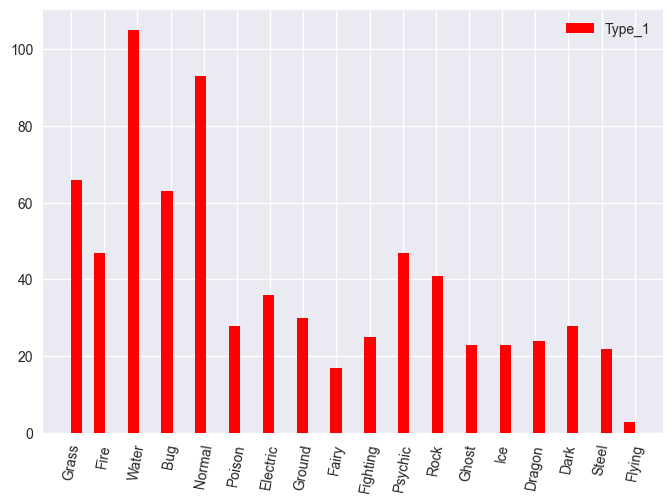

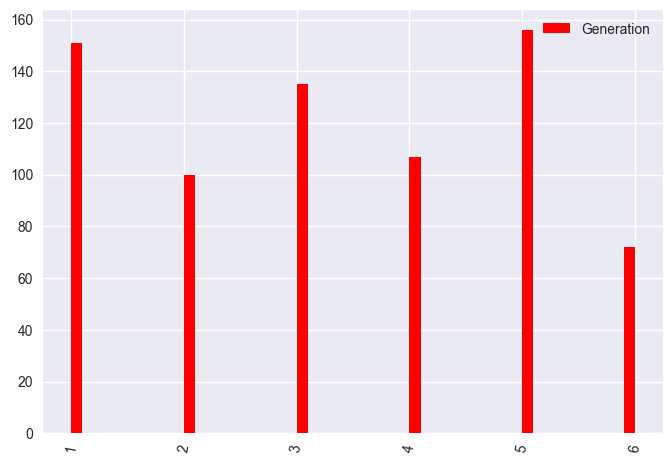

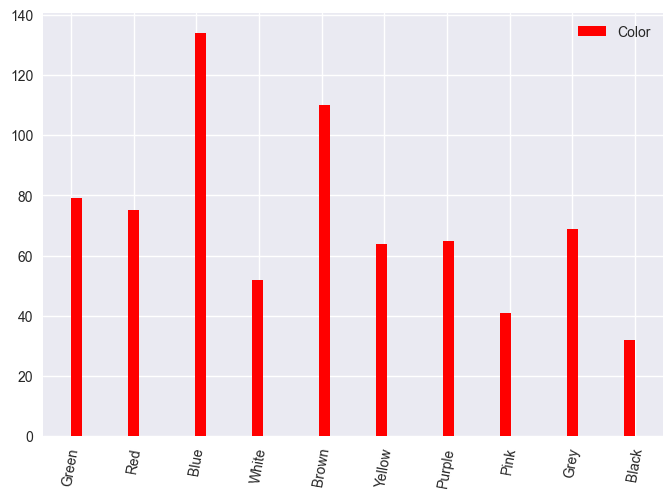

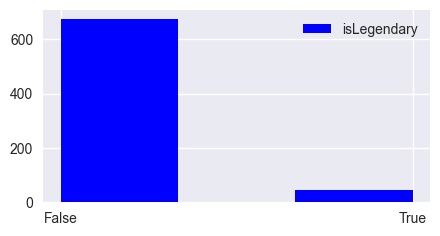

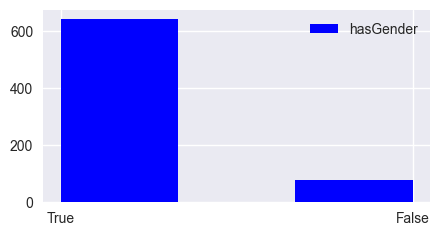

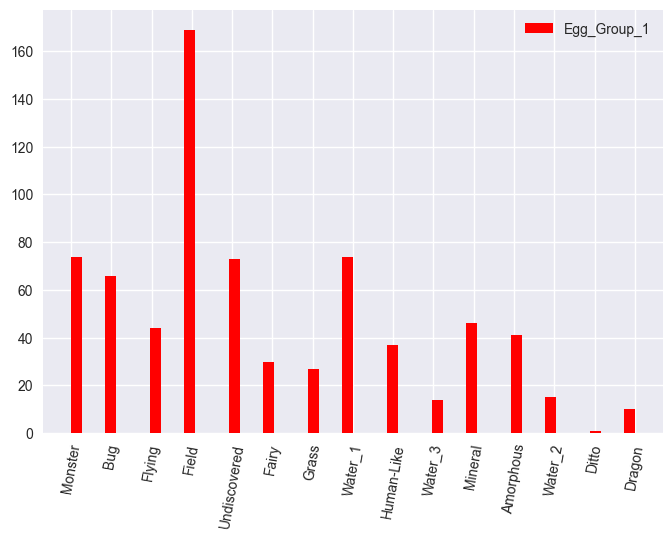

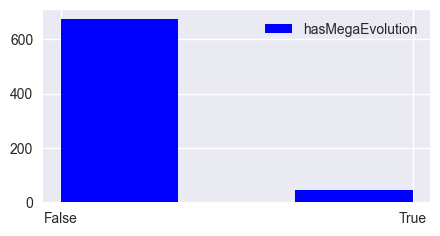

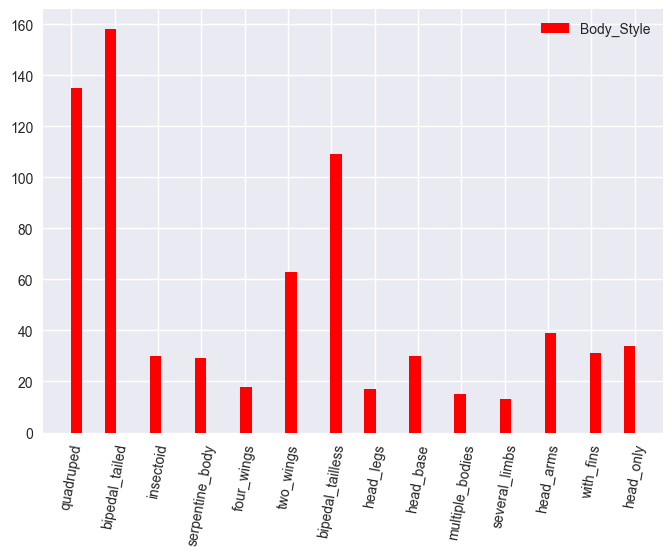

In [14]:
categorical_columns = ['Type_1', 'Generation', 'Color','isLegendary', 'hasGender', 'Egg_Group_1', 'hasMegaEvolution', 'Body_Style']
for column in categorical_columns:
    
    label = [column]
    
    if type(copy_pokemons[column][0]) == np.bool_:
        
        plt.figure(figsize=(5, 2.5))
        plt.hist(copy_pokemons[column].astype(str), bins=3, color='blue')
        
        plt.legend(label)
        plt.show()
    
    else:
        
        plt.figure()     
        plt.hist(copy_pokemons[column], bins=50, color='red')
        
        plt.xticks(fontsize = 10, horizontalalignment = 'center', rotation = 80)
        plt.legend(label)
        plt.show()

### Analizo las relaciones entre mis variables categoricas con el test de independencia chi-cuadrado

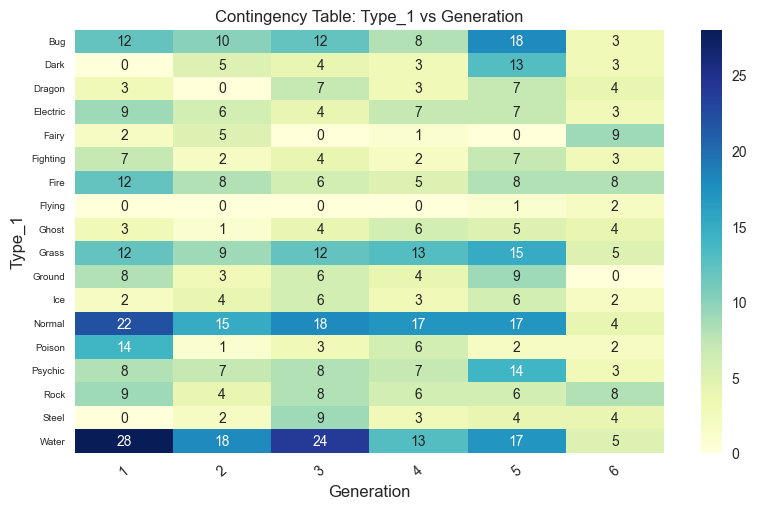

Var 1: Type_1,
Var 2: Generation,
Chi2: 12.512492664594646,
P-Value: 0.0000037245,
Cramér's V: 0.2083968745732762,
Degrees of Freedom: 85,
Expected Frequencies: [[13.19417476  8.73786408 11.7961165   9.34951456 13.63106796  6.29126214]
 [ 5.86407767  3.88349515  5.24271845  4.15533981  6.05825243  2.7961165 ]
 [ 5.02635229  3.32871012  4.49375867  3.56171983  5.19278779  2.39667129]
 [ 7.53952843  4.99306519  6.740638    5.34257975  7.78918169  3.59500693]
 [ 3.56033287  2.35783634  3.18307906  2.52288488  3.67822469  1.69764216]
 [ 5.23578363  3.46740638  4.68099861  3.71012483  5.40915395  2.49653259]
 [ 9.84327323  6.51872399  8.80027739  6.97503467 10.16920943  4.69348128]
 [ 0.62829404  0.41608877  0.56171983  0.44521498  0.64909847  0.29958391]
 [ 4.81692094  3.19001387  4.30651872  3.41331484  4.97642164  2.29680999]
 [13.82246879  9.15395284 12.35783634  9.79472954 14.28016644  6.59084605]
 [ 6.28294036  4.16088766  5.61719834  4.45214979  6.49098474  2.99583911]
 [ 4.81692094 

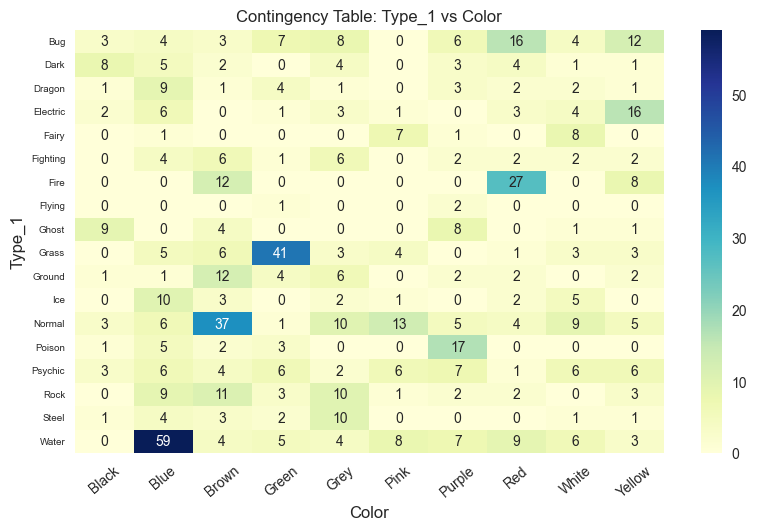

Var 1: Type_1,
Var 2: Color,
Chi2: 32.74243762516262,
P-Value: 0.0000000000,
Cramér's V: 0.40646403280132115,
Degrees of Freedom: 153,
Expected Frequencies: [[ 2.7961165  11.70873786  9.61165049  6.90291262  6.02912621  3.58252427
   5.67961165  6.55339806  4.54368932  5.59223301]
 [ 1.24271845  5.2038835   4.27184466  3.06796117  2.67961165  1.59223301
   2.52427184  2.91262136  2.01941748  2.48543689]
 [ 1.06518724  4.46047157  3.66158114  2.629681    2.29680999  1.36477115
   2.16366158  2.49653259  1.73092926  2.13037448]
 [ 1.59778086  6.69070735  5.49237171  3.9445215   3.44521498  2.04715673
   3.24549237  3.74479889  2.5963939   3.19556172]
 [ 0.75450763  3.15950069  2.59361997  1.86269071  1.62690707  0.9667129
   1.53259362  1.76837725  1.2260749   1.50901526]
 [ 1.10957004  4.64632455  3.81414702  2.73925104  2.3925104   1.42163662
   2.25381415  2.60055479  1.80305132  2.21914008]
 [ 2.08599168  8.73509015  7.17059639  5.14979196  4.49791956  2.67267684
   4.2371706   4.889

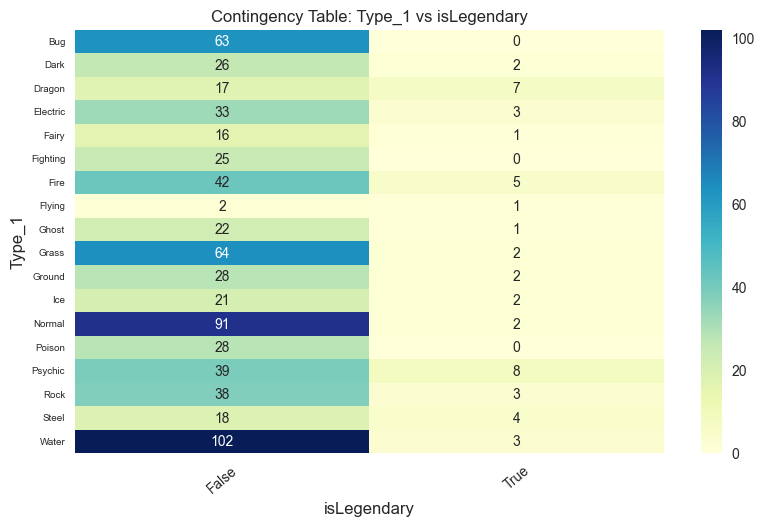

Var 1: Type_1,
Var 2: isLegendary,
Chi2: 7.401721104567872,
P-Value: 0.0000074175,
Cramér's V: 0.27565449869143915,
Degrees of Freedom: 17,
Expected Frequencies: [[58.98058252  4.01941748]
 [26.21359223  1.78640777]
 [22.46879334  1.53120666]
 [33.70319001  2.29680999]
 [15.91539528  1.08460472]
 [23.40499307  1.59500693]
 [44.00138696  2.99861304]
 [ 2.80859917  0.19140083]
 [21.53259362  1.46740638]
 [61.78918169  4.21081831]
 [28.08599168  1.91400832]
 [21.53259362  1.46740638]
 [87.0665742   5.9334258 ]
 [26.21359223  1.78640777]
 [44.00138696  2.99861304]
 [38.38418863  2.61581137]
 [20.5963939   1.4036061 ]
 [98.30097087  6.69902913]]


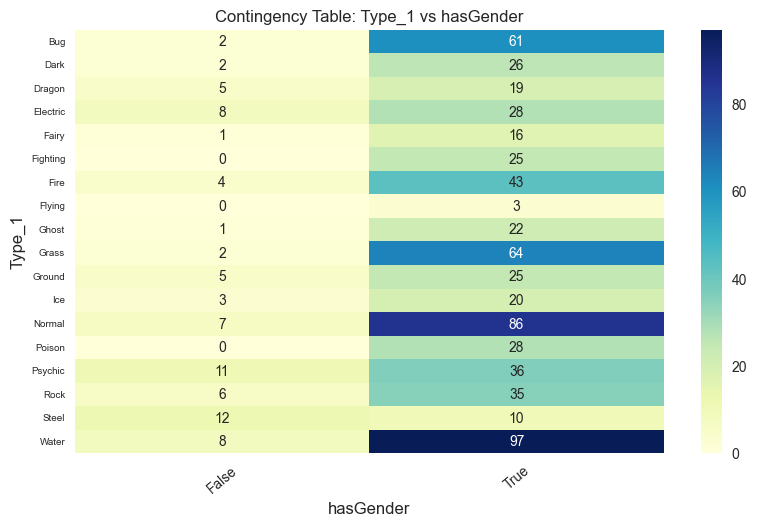

Var 1: Type_1,
Var 2: hasGender,
Chi2: 8.963931614314305,
P-Value: 0.0000000003,
Cramér's V: 0.33383425834881025,
Degrees of Freedom: 17,
Expected Frequencies: [[ 6.72815534 56.27184466]
 [ 2.99029126 25.00970874]
 [ 2.5631068  21.4368932 ]
 [ 3.84466019 32.15533981]
 [ 1.81553398 15.18446602]
 [ 2.66990291 22.33009709]
 [ 5.01941748 41.98058252]
 [ 0.32038835  2.67961165]
 [ 2.45631068 20.54368932]
 [ 7.04854369 58.95145631]
 [ 3.2038835  26.7961165 ]
 [ 2.45631068 20.54368932]
 [ 9.93203883 83.06796117]
 [ 2.99029126 25.00970874]
 [ 5.01941748 41.98058252]
 [ 4.37864078 36.62135922]
 [ 2.34951456 19.65048544]
 [11.21359223 93.78640777]]


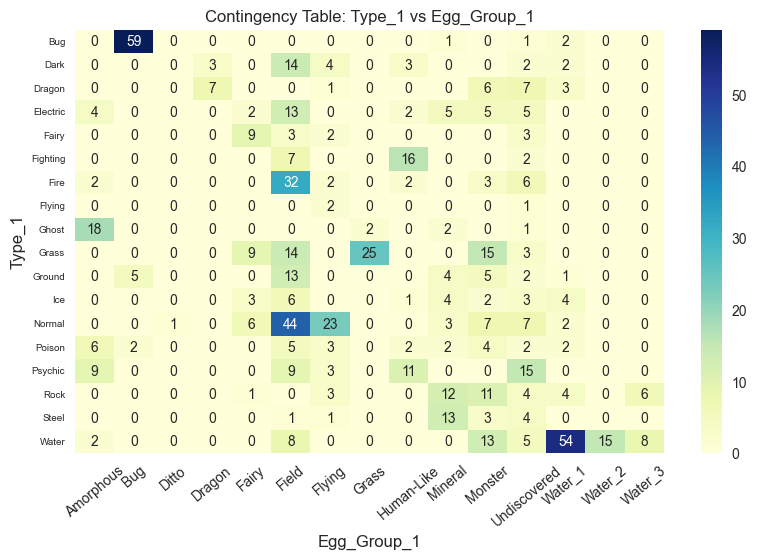

Var 1: Type_1,
Var 2: Egg_Group_1,
Chi2: 49.38080626688574,
P-Value: 0.0000000000,
Cramér's V: 0.49150339997825293,
Degrees of Freedom: 238,
Expected Frequencies: [[3.58252427e+00 5.76699029e+00 8.73786408e-02 8.73786408e-01
  2.62135922e+00 1.47669903e+01 3.84466019e+00 2.35922330e+00
  3.23300971e+00 4.01941748e+00 6.46601942e+00 6.37864078e+00
  6.46601942e+00 1.31067961e+00 1.22330097e+00]
 [1.59223301e+00 2.56310680e+00 3.88349515e-02 3.88349515e-01
  1.16504854e+00 6.56310680e+00 1.70873786e+00 1.04854369e+00
  1.43689320e+00 1.78640777e+00 2.87378641e+00 2.83495146e+00
  2.87378641e+00 5.82524272e-01 5.43689320e-01]
 [1.36477115e+00 2.19694868e+00 3.32871012e-02 3.32871012e-01
  9.98613037e-01 5.62552011e+00 1.46463245e+00 8.98751734e-01
  1.23162275e+00 1.53120666e+00 2.46324549e+00 2.42995839e+00
  2.46324549e+00 4.99306519e-01 4.66019417e-01]
 [2.04715673e+00 3.29542302e+00 4.99306519e-02 4.99306519e-01
  1.49791956e+00 8.43828017e+00 2.19694868e+00 1.34812760e+00
  1.8474341

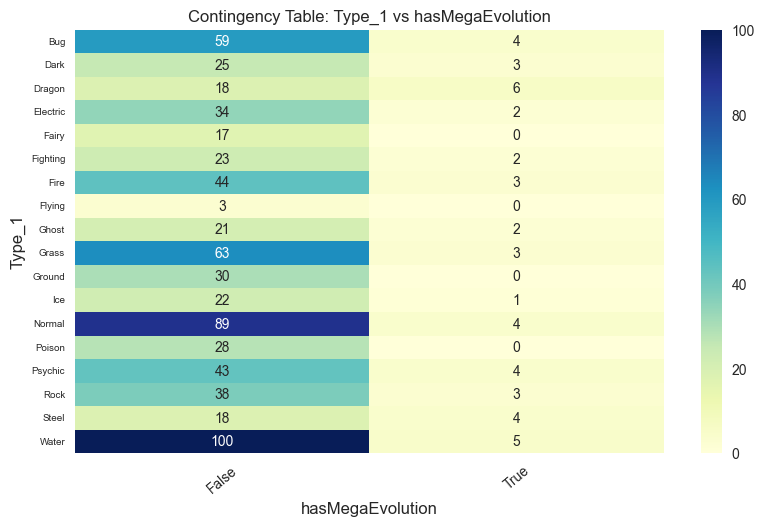

Var 1: Type_1,
Var 2: hasMegaEvolution,
Chi2: 5.262717356273527,
P-Value: 0.0486156818,
Cramér's V: 0.19599383631234638,
Degrees of Freedom: 17,
Expected Frequencies: [[58.98058252  4.01941748]
 [26.21359223  1.78640777]
 [22.46879334  1.53120666]
 [33.70319001  2.29680999]
 [15.91539528  1.08460472]
 [23.40499307  1.59500693]
 [44.00138696  2.99861304]
 [ 2.80859917  0.19140083]
 [21.53259362  1.46740638]
 [61.78918169  4.21081831]
 [28.08599168  1.91400832]
 [21.53259362  1.46740638]
 [87.0665742   5.9334258 ]
 [26.21359223  1.78640777]
 [44.00138696  2.99861304]
 [38.38418863  2.61581137]
 [20.5963939   1.4036061 ]
 [98.30097087  6.69902913]]


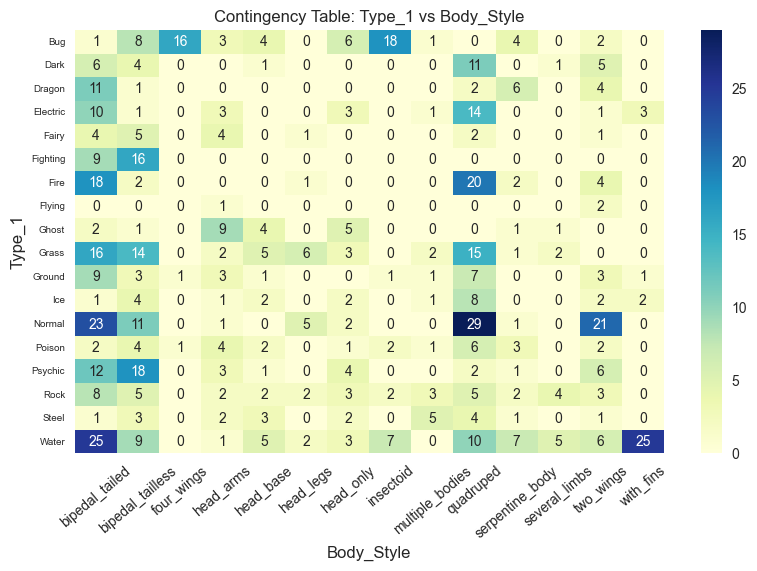

Var 1: Type_1,
Var 2: Body_Style,
Chi2: 30.424903142561703,
P-Value: 0.0000000000,
Cramér's V: 0.3142605713985739,
Degrees of Freedom: 221,
Expected Frequencies: [[13.80582524  9.52427184  1.57281553  3.40776699  2.62135922  1.48543689
   2.97087379  2.62135922  1.31067961 11.7961165   2.53398058  1.13592233
   5.50485437  2.70873786]
 [ 6.13592233  4.23300971  0.69902913  1.51456311  1.16504854  0.66019417
   1.32038835  1.16504854  0.58252427  5.24271845  1.12621359  0.50485437
   2.44660194  1.2038835 ]
 [ 5.259362    3.62829404  0.59916782  1.29819695  0.99861304  0.56588072
   1.13176144  0.99861304  0.49930652  4.49375867  0.96532594  0.43273232
   2.09708738  1.03190014]
 [ 7.889043    5.44244105  0.89875173  1.94729542  1.49791956  0.84882108
   1.69764216  1.49791956  0.74895978  6.740638    1.4479889   0.64909847
   3.14563107  1.54785021]
 [ 3.72538141  2.57004161  0.42441054  0.91955617  0.7073509   0.40083218
   0.80166436  0.7073509   0.35367545  3.18307906  0.68377254  0

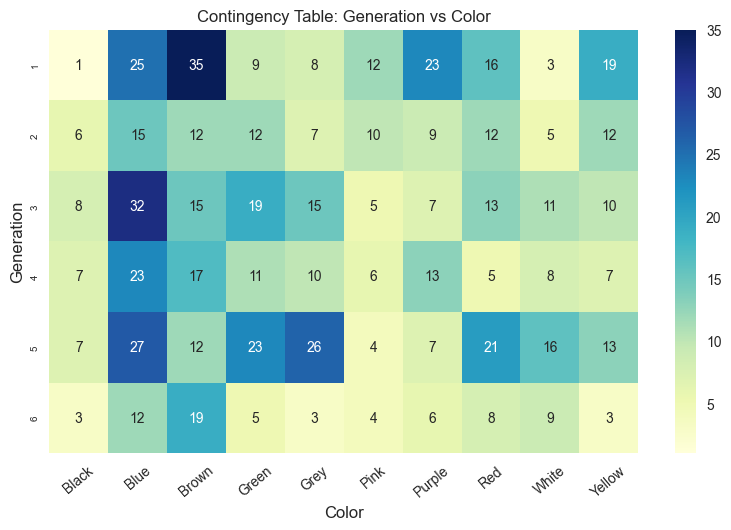

Var 1: Generation,
Var 2: Color,
Chi2: 9.8814844681843,
P-Value: 0.0000092495,
Cramér's V: 0.16457715776656498,
Degrees of Freedom: 45,
Expected Frequencies: [[ 6.70180305 28.06380028 23.03744799 16.54507628 14.45076283  8.58668516
  13.61303745 15.7073509  10.89042996 13.4036061 ]
 [ 4.43828017 18.5852982  15.25658807 10.95700416  9.57004161  5.68654646
   9.01525659 10.40221914  7.21220527  8.87656033]
 [ 5.99167822 25.09015257 20.5963939  14.79195562 12.91955617  7.67683773
  12.17059639 14.04299584  9.73647712 11.98335645]
 [ 4.74895978 19.88626907 16.32454924 11.72399445 10.23994452  6.08460472
   9.64632455 11.13037448  7.71705964  9.49791956]
 [ 6.92371706 28.99306519 23.80027739 17.09292649 14.92926491  8.87101248
  14.06380028 16.22746186 11.25104022 13.84743412]
 [ 3.19556172 13.3814147  10.98474341  7.889043    6.89042996  4.09431345
   6.49098474  7.48959778  5.19278779  6.39112344]]


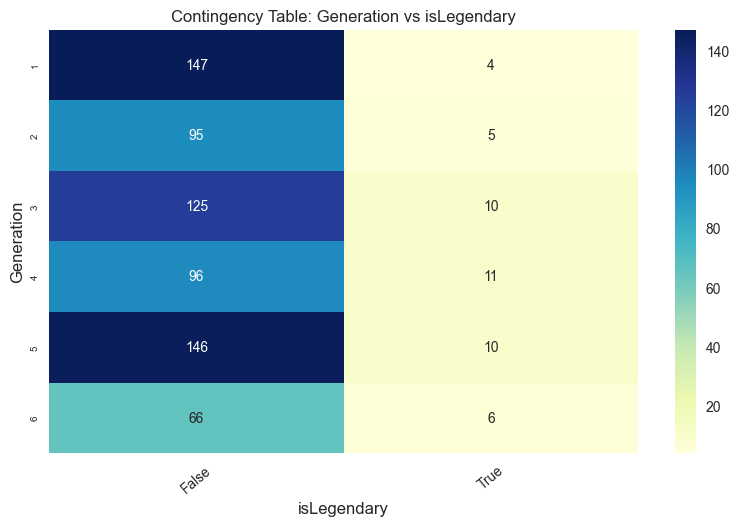

Var 1: Generation,
Var 2: isLegendary,
Chi2: 2.694801085033922,
P-Value: 0.2018760598,
Cramér's V: 0.10035963685658761,
Degrees of Freedom: 5,
Expected Frequencies: [[141.36615811   9.63384189]
 [ 93.61997226   6.38002774]
 [126.38696255   8.61303745]
 [100.17337032   6.82662968]
 [146.04715673   9.95284327]
 [ 67.40638003   4.59361997]]


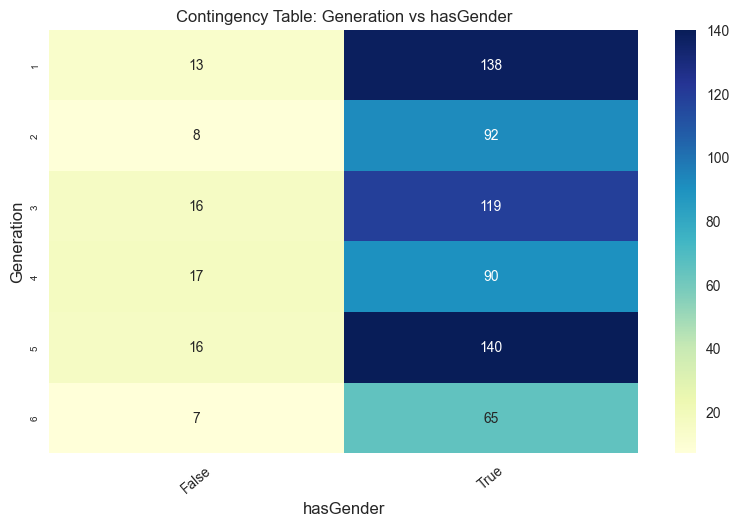

Var 1: Generation,
Var 2: hasGender,
Chi2: 2.1833194172402917,
P-Value: 0.4449873108,
Cramér's V: 0.08131106413496708,
Degrees of Freedom: 5,
Expected Frequencies: [[ 16.12621359 134.87378641]
 [ 10.67961165  89.32038835]
 [ 14.41747573 120.58252427]
 [ 11.42718447  95.57281553]
 [ 16.66019417 139.33980583]
 [  7.68932039  64.31067961]]


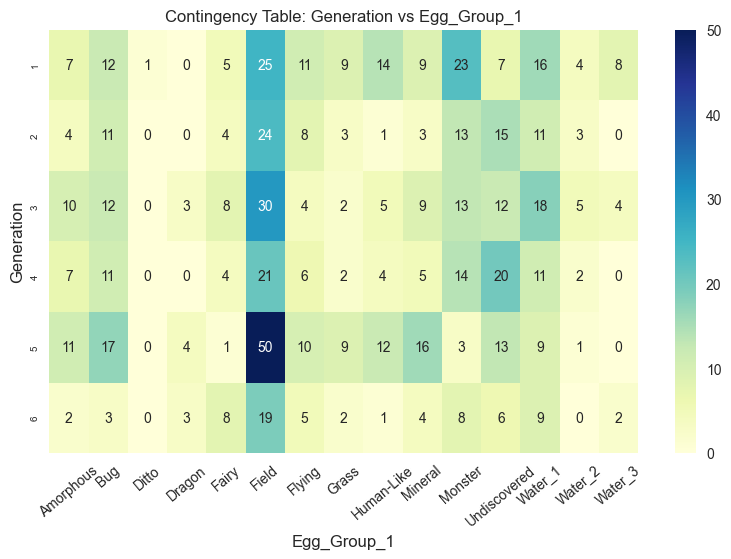

Var 1: Generation,
Var 2: Egg_Group_1,
Chi2: 11.51638916501431,
P-Value: 0.0000092131,
Cramér's V: 0.19180666656049333,
Degrees of Freedom: 70,
Expected Frequencies: [[ 8.58668516 13.82246879  0.20943135  2.09431345  6.28294036 35.39389736
   9.2149792   5.65464632  7.74895978  9.63384189 15.49791956 15.28848821
  15.49791956  3.14147018  2.93203883]
 [ 5.68654646  9.15395284  0.13869626  1.38696255  4.16088766 23.43966713
   6.10263523  3.74479889  5.13176144  6.38002774 10.26352288 10.12482663
  10.26352288  2.08044383  1.94174757]
 [ 7.67683773 12.35783634  0.18723994  1.87239945  5.61719834 31.64355062
   8.23855756  5.0554785   6.92787795  8.61303745 13.85575589 13.66851595
  13.85575589  2.80859917  2.62135922]
 [ 6.08460472  9.79472954  0.14840499  1.48404993  4.45214979 25.08044383
   6.52981969  4.00693481  5.49098474  6.82662968 10.98196949 10.83356449
  10.98196949  2.2260749   2.0776699 ]
 [ 8.87101248 14.28016644  0.21636616  2.16366158  6.49098474 36.56588072
   9.5201109

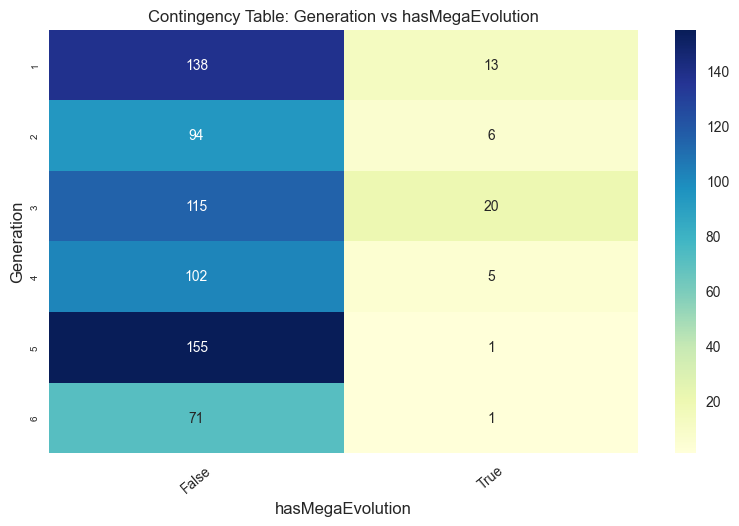

Var 1: Generation,
Var 2: hasMegaEvolution,
Chi2: 5.430265565033183,
P-Value: 0.0000185988,
Cramér's V: 0.2022336576781891,
Degrees of Freedom: 5,
Expected Frequencies: [[141.36615811   9.63384189]
 [ 93.61997226   6.38002774]
 [126.38696255   8.61303745]
 [100.17337032   6.82662968]
 [146.04715673   9.95284327]
 [ 67.40638003   4.59361997]]


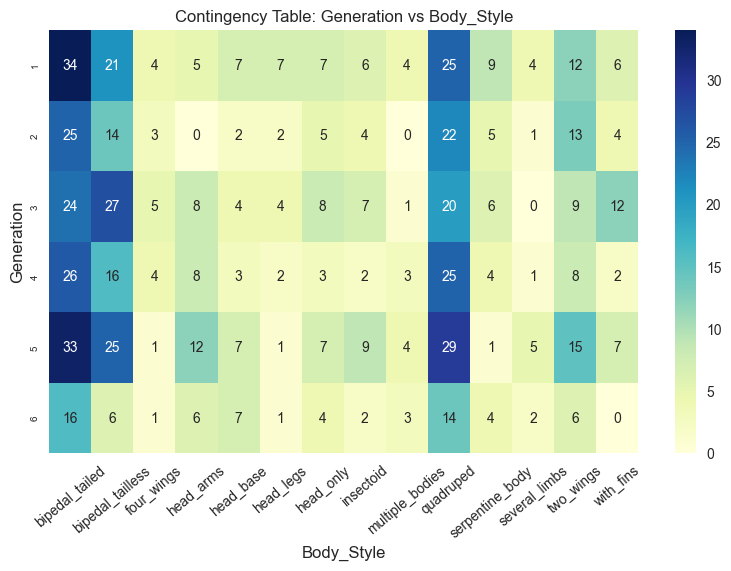

Var 1: Generation,
Var 2: Body_Style,
Chi2: 8.619112928553768,
P-Value: 0.2013828183,
Cramér's V: 0.1435522276857944,
Degrees of Freedom: 65,
Expected Frequencies: [[33.09015257 22.82801664  3.76976422  8.16782247  6.28294036  3.56033287
   7.12066574  6.28294036  3.14147018 28.27323162  6.07350902  2.72260749
  13.19417476  6.49237171]
 [21.91400832 15.11789182  2.49653259  5.40915395  4.16088766  2.35783634
   4.71567268  4.16088766  2.08044383 18.72399445  4.0221914   1.80305132
   8.73786408  4.29958391]
 [29.58391123 20.40915395  3.370319    7.30235784  5.61719834  3.18307906
   6.36615811  5.61719834  2.80859917 25.27739251  5.42995839  2.43411928
  11.7961165   5.80443828]
 [23.4479889  16.17614424  2.67128988  5.78779473  4.45214979  2.52288488
   5.04576976  4.45214979  2.2260749  20.03467406  4.3037448   1.92926491
   9.34951456  4.60055479]
 [34.18585298 23.58391123  3.89459085  8.43828017  6.49098474  3.67822469
   7.35644938  6.49098474  3.24549237 29.20943135  6.27461859 

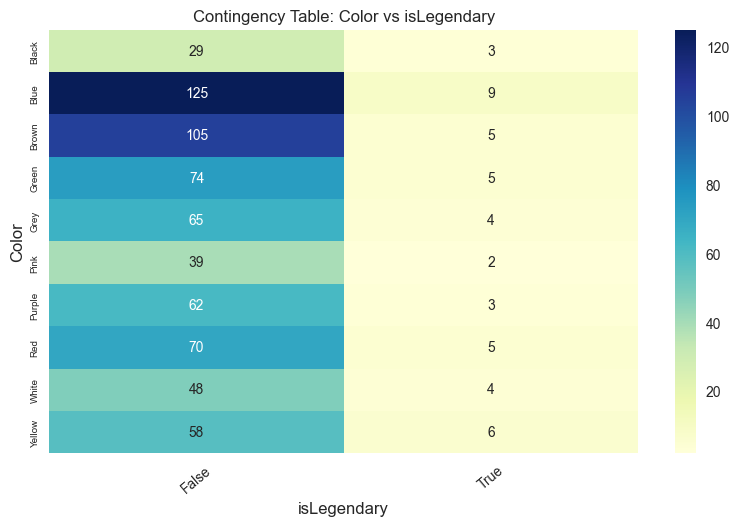

Var 1: Color,
Var 2: isLegendary,
Chi2: 1.66746693811041,
P-Value: 0.9723672001,
Cramér's V: 0.06209971389299044,
Degrees of Freedom: 9,
Expected Frequencies: [[ 29.95839112   2.04160888]
 [125.45076283   8.54923717]
 [102.98196949   7.01803051]
 [ 73.95977809   5.04022191]
 [ 64.59778086   4.40221914]
 [ 38.38418863   2.61581137]
 [ 60.85298197   4.14701803]
 [ 70.2149792    4.7850208 ]
 [ 48.68238558   3.31761442]
 [ 59.91678225   4.08321775]]


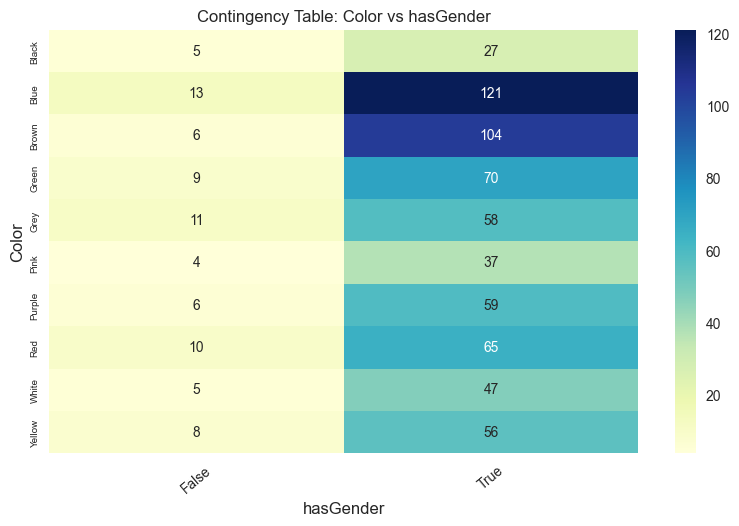

Var 1: Color,
Var 2: hasGender,
Chi2: 2.6768959647733728,
P-Value: 0.6198648423,
Cramér's V: 0.09969281533228216,
Degrees of Freedom: 9,
Expected Frequencies: [[  3.41747573  28.58252427]
 [ 14.31067961 119.68932039]
 [ 11.74757282  98.25242718]
 [  8.4368932   70.5631068 ]
 [  7.36893204  61.63106796]
 [  4.37864078  36.62135922]
 [  6.94174757  58.05825243]
 [  8.00970874  66.99029126]
 [  5.55339806  46.44660194]
 [  6.83495146  57.16504854]]


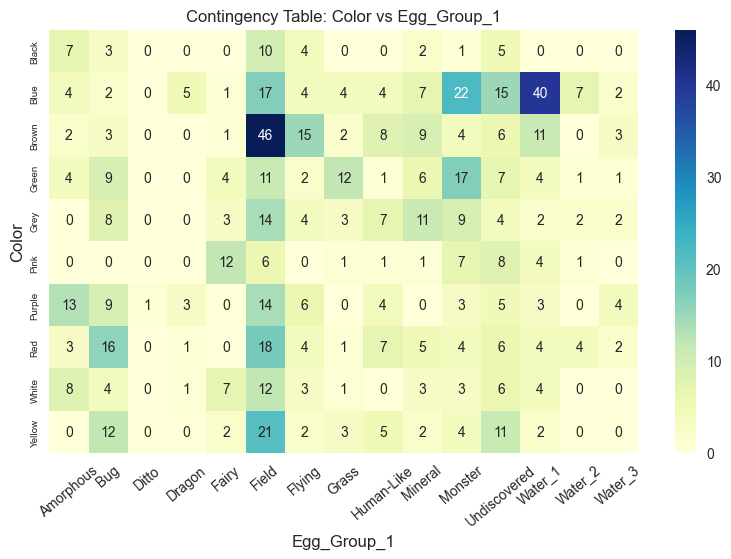

Var 1: Color,
Var 2: Egg_Group_1,
Chi2: 21.647254683678735,
P-Value: 0.0000000000,
Cramér's V: 0.2687286309753379,
Degrees of Freedom: 126,
Expected Frequencies: [[ 1.81969487  2.92926491  0.0443828   0.44382802  1.33148405  7.50069348
   1.95284327  1.19833564  1.64216366  2.04160888  3.28432732  3.23994452
   3.28432732  0.66574202  0.62135922]
 [ 7.61997226 12.26629681  0.18585298  1.85852982  5.57558946 31.40915395
   8.17753121  5.01803051  6.87656033  8.54923717 13.75312067 13.56726768
  13.75312067  2.78779473  2.60194175]
 [ 6.25520111 10.06934813  0.15256588  1.52565881  4.57697642 25.78363384
   6.71289875  4.11927878  5.64493759  7.01803051 11.28987517 11.13730929
  11.28987517  2.28848821  2.13592233]
 [ 4.49237171  7.23162275  0.10957004  1.09570042  3.28710125 18.51733703
   4.82108183  2.95839112  4.05409154  5.04022191  8.10818308  7.99861304
   8.10818308  1.64355062  1.53398058]
 [ 3.92371706  6.31622746  0.09570042  0.95700416  2.87101248 16.17337032
   4.21081831  2

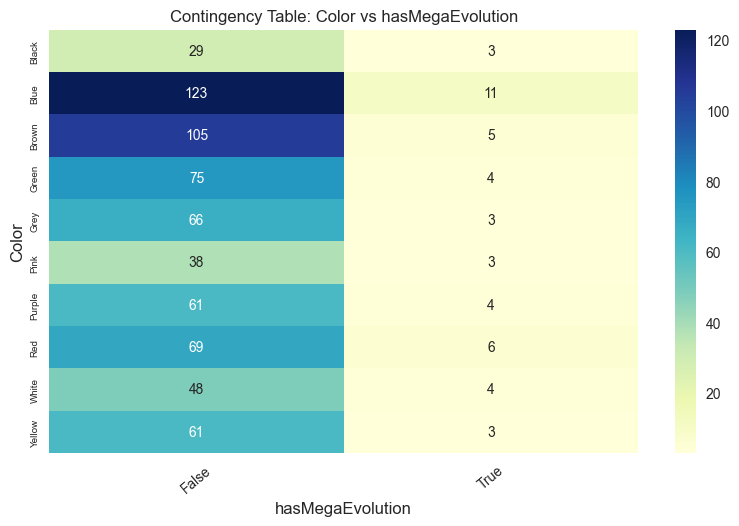

Var 1: Color,
Var 2: hasMegaEvolution,
Chi2: 1.8464652774686094,
P-Value: 0.9458319266,
Cramér's V: 0.06876596040583649,
Degrees of Freedom: 9,
Expected Frequencies: [[ 29.95839112   2.04160888]
 [125.45076283   8.54923717]
 [102.98196949   7.01803051]
 [ 73.95977809   5.04022191]
 [ 64.59778086   4.40221914]
 [ 38.38418863   2.61581137]
 [ 60.85298197   4.14701803]
 [ 70.2149792    4.7850208 ]
 [ 48.68238558   3.31761442]
 [ 59.91678225   4.08321775]]


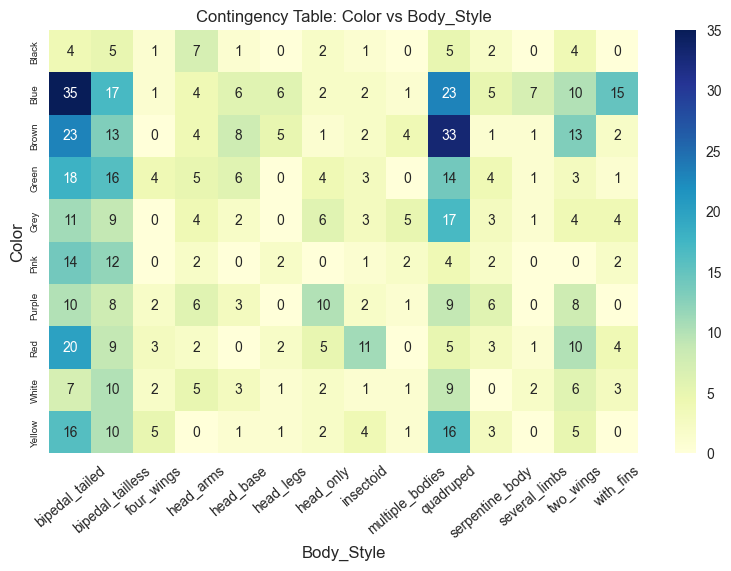

Var 1: Color,
Var 2: Body_Style,
Chi2: 15.426581539325023,
P-Value: 0.0000000003,
Cramér's V: 0.1915053062510436,
Degrees of Freedom: 117,
Expected Frequencies: [[ 7.01248266  4.83772538  0.79889043  1.73092926  1.33148405  0.75450763
   1.50901526  1.33148405  0.66574202  5.99167822  1.28710125  0.57697642
   2.7961165   1.37586685]
 [29.36477115 20.25797503  3.34535368  7.2482663   5.57558946  3.15950069
   6.31900139  5.57558946  2.78779473 25.09015257  5.38973648  2.41608877
  11.70873786  5.76144244]
 [24.10540915 16.629681    2.74618585  5.95006935  4.57697642  2.59361997
   5.18723994  4.57697642  2.28848821 20.5963939   4.42441054  1.98335645
   9.61165049  4.7295423 ]
 [17.31206657 11.94313454  1.97226075  4.27323162  3.28710125  1.86269071
   3.72538141  3.28710125  1.64355062 14.79195562  3.17753121  1.42441054
   6.90291262  3.39667129]
 [15.12066574 10.43134535  1.72260749  3.73231623  2.87101248  1.62690707
   3.25381415  2.87101248  1.43550624 12.91955617  2.77531207  1.

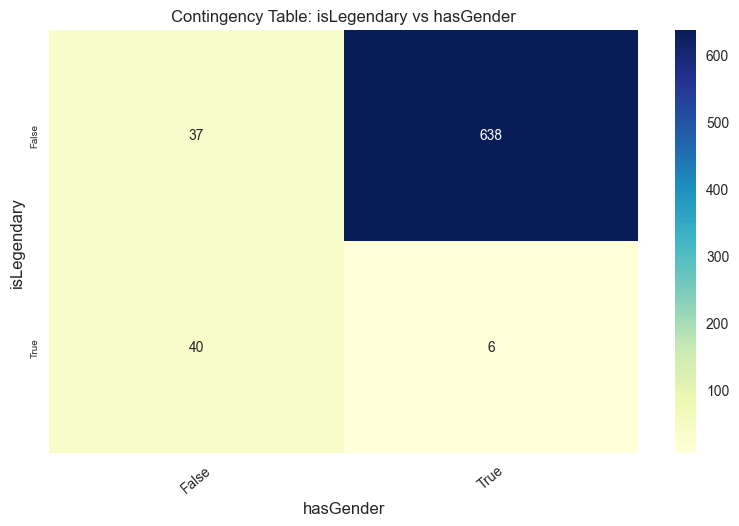

Var 1: isLegendary,
Var 2: hasGender,
Chi2: 17.064809594164174,
P-Value: 0.0000000000,
Cramér's V: 0.6355267197302505,
Degrees of Freedom: 1,
Expected Frequencies: [[ 72.08737864 602.91262136]
 [  4.91262136  41.08737864]]


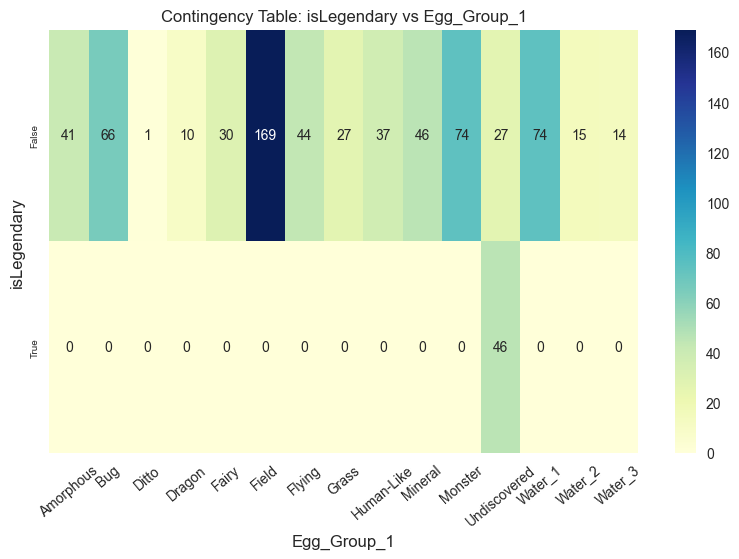

Var 1: isLegendary,
Var 2: Egg_Group_1,
Chi2: 20.884339023257503,
P-Value: 0.0000000000,
Cramér's V: 0.7777734289941481,
Degrees of Freedom: 14,
Expected Frequencies: [[3.83841886e+01 6.17891817e+01 9.36199723e-01 9.36199723e+00
  2.80859917e+01 1.58217753e+02 4.11927878e+01 2.52773925e+01
  3.46393897e+01 4.30651872e+01 6.92787795e+01 6.83425798e+01
  6.92787795e+01 1.40429958e+01 1.31067961e+01]
 [2.61581137e+00 4.21081831e+00 6.38002774e-02 6.38002774e-01
  1.91400832e+00 1.07822469e+01 2.80721221e+00 1.72260749e+00
  2.36061026e+00 2.93481276e+00 4.72122053e+00 4.65742025e+00
  4.72122053e+00 9.57004161e-01 8.93203883e-01]]


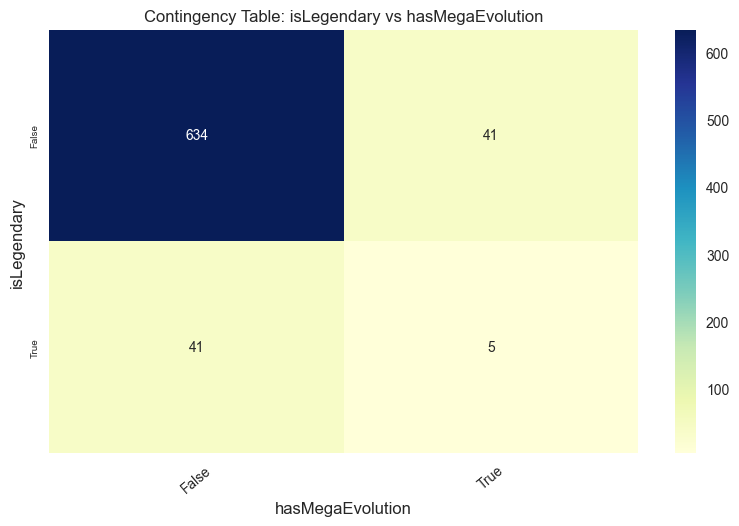

Var 1: isLegendary,
Var 2: hasMegaEvolution,
Chi2: 0.9759051082381377,
P-Value: 0.3291114905,
Cramér's V: 0.03634460547504026,
Degrees of Freedom: 1,
Expected Frequencies: [[631.93481276  43.06518724]
 [ 43.06518724   2.93481276]]


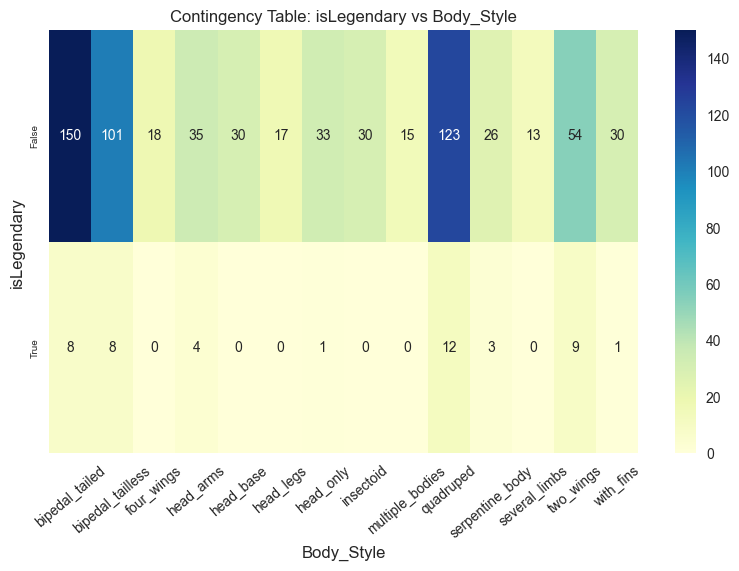

Var 1: isLegendary,
Var 2: Body_Style,
Chi2: 4.46738363951163,
P-Value: 0.0962746458,
Cramér's V: 0.16637406087240167,
Degrees of Freedom: 13,
Expected Frequencies: [[147.91955617 102.04576976  16.85159501  36.51178918  28.08599168
   15.91539528  31.83079057  28.08599168  14.04299584 126.38696255
   27.14979196  12.17059639  58.98058252  29.0221914 ]
 [ 10.08044383   6.95423024   1.14840499   2.48821082   1.91400832
    1.08460472   2.16920943   1.91400832   0.95700416   8.61303745
    1.85020804   0.82940361   4.01941748   1.9778086 ]]


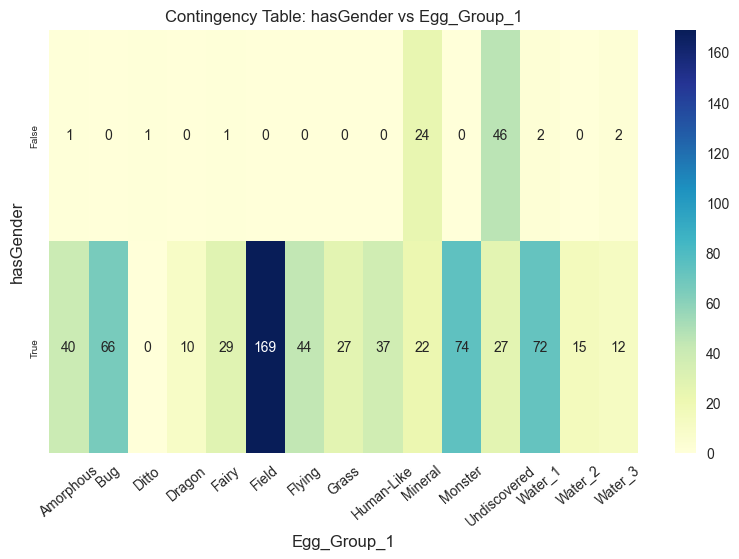

Var 1: hasGender,
Var 2: Egg_Group_1,
Chi2: 19.06779545549938,
P-Value: 0.0000000000,
Cramér's V: 0.7101218112896523,
Degrees of Freedom: 14,
Expected Frequencies: [[4.37864078e+00 7.04854369e+00 1.06796117e-01 1.06796117e+00
  3.20388350e+00 1.80485437e+01 4.69902913e+00 2.88349515e+00
  3.95145631e+00 4.91262136e+00 7.90291262e+00 7.79611650e+00
  7.90291262e+00 1.60194175e+00 1.49514563e+00]
 [3.66213592e+01 5.89514563e+01 8.93203883e-01 8.93203883e+00
  2.67961165e+01 1.50951456e+02 3.93009709e+01 2.41165049e+01
  3.30485437e+01 4.10873786e+01 6.60970874e+01 6.52038835e+01
  6.60970874e+01 1.33980583e+01 1.25048544e+01]]


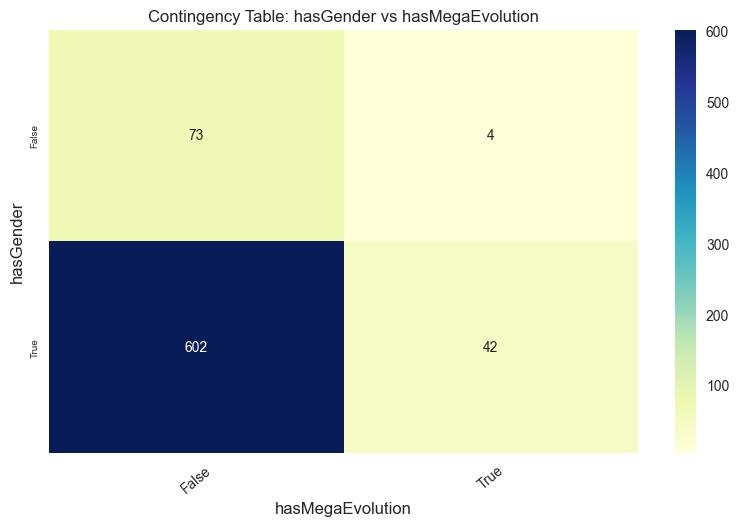

Var 1: hasGender,
Var 2: hasMegaEvolution,
Chi2: 0.20358018463213368,
P-Value: 0.8386815792,
Cramér's V: 0.007581722270466134,
Degrees of Freedom: 1,
Expected Frequencies: [[ 72.08737864   4.91262136]
 [602.91262136  41.08737864]]


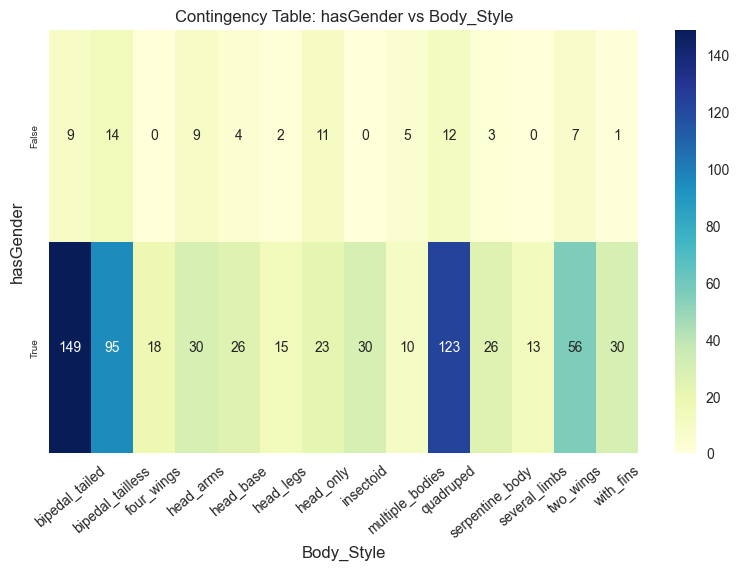

Var 1: hasGender,
Var 2: Body_Style,
Chi2: 6.74951186335871,
P-Value: 0.0000168978,
Cramér's V: 0.25136495726080027,
Degrees of Freedom: 13,
Expected Frequencies: [[ 16.87378641  11.6407767    1.9223301    4.16504854   3.2038835
    1.81553398   3.63106796   3.2038835    1.60194175  14.41747573
    3.09708738   1.38834951   6.72815534   3.31067961]
 [141.12621359  97.3592233   16.0776699   34.83495146  26.7961165
   15.18446602  30.36893204  26.7961165   13.39805825 120.58252427
   25.90291262  11.61165049  56.27184466  27.68932039]]


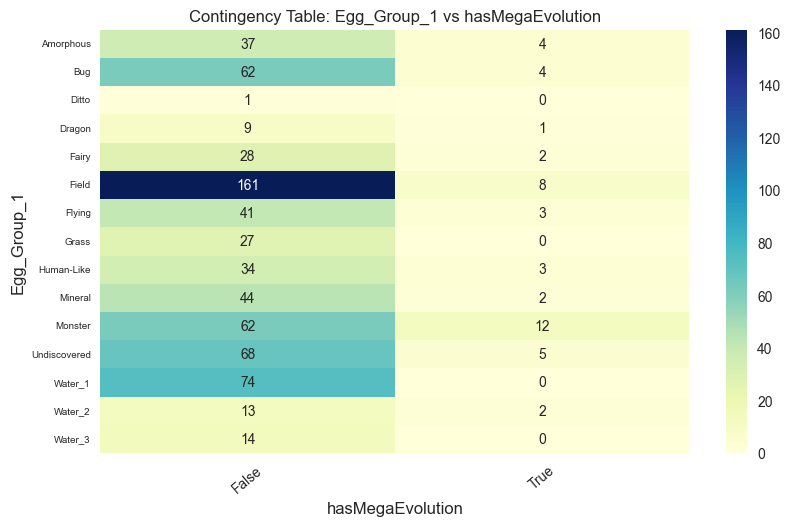

Var 1: Egg_Group_1,
Var 2: hasMegaEvolution,
Chi2: 4.840871752038744,
P-Value: 0.0535635520,
Cramér's V: 0.18028348504164482,
Degrees of Freedom: 14,
Expected Frequencies: [[3.83841886e+01 2.61581137e+00]
 [6.17891817e+01 4.21081831e+00]
 [9.36199723e-01 6.38002774e-02]
 [9.36199723e+00 6.38002774e-01]
 [2.80859917e+01 1.91400832e+00]
 [1.58217753e+02 1.07822469e+01]
 [4.11927878e+01 2.80721221e+00]
 [2.52773925e+01 1.72260749e+00]
 [3.46393897e+01 2.36061026e+00]
 [4.30651872e+01 2.93481276e+00]
 [6.92787795e+01 4.72122053e+00]
 [6.83425798e+01 4.65742025e+00]
 [6.92787795e+01 4.72122053e+00]
 [1.40429958e+01 9.57004161e-01]
 [1.31067961e+01 8.93203883e-01]]


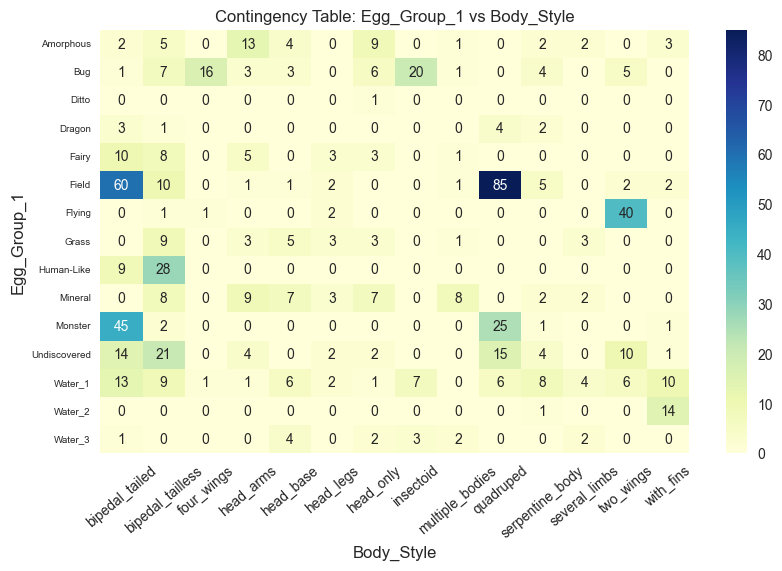

Var 1: Egg_Group_1,
Var 2: Body_Style,
Chi2: 42.57668268841684,
P-Value: 0.0000000000,
Cramér's V: 0.43977700001943426,
Degrees of Freedom: 182,
Expected Frequencies: [[8.98474341e+00 6.19833564e+00 1.02357836e+00 2.21775312e+00
  1.70596394e+00 9.66712899e-01 1.93342580e+00 1.70596394e+00
  8.52981969e-01 7.67683773e+00 1.64909847e+00 7.39251040e-01
  3.58252427e+00 1.76282940e+00]
 [1.44632455e+01 9.97780860e+00 1.64771151e+00 3.57004161e+00
  2.74618585e+00 1.55617198e+00 3.11234397e+00 2.74618585e+00
  1.37309293e+00 1.23578363e+01 2.65464632e+00 1.19001387e+00
  5.76699029e+00 2.83772538e+00]
 [2.19140083e-01 1.51178918e-01 2.49653259e-02 5.40915395e-02
  4.16088766e-02 2.35783634e-02 4.71567268e-02 4.16088766e-02
  2.08044383e-02 1.87239945e-01 4.02219140e-02 1.80305132e-02
  8.73786408e-02 4.29958391e-02]
 [2.19140083e+00 1.51178918e+00 2.49653259e-01 5.40915395e-01
  4.16088766e-01 2.35783634e-01 4.71567268e-01 4.16088766e-01
  2.08044383e-01 1.87239945e+00 4.02219140e-01 1.803

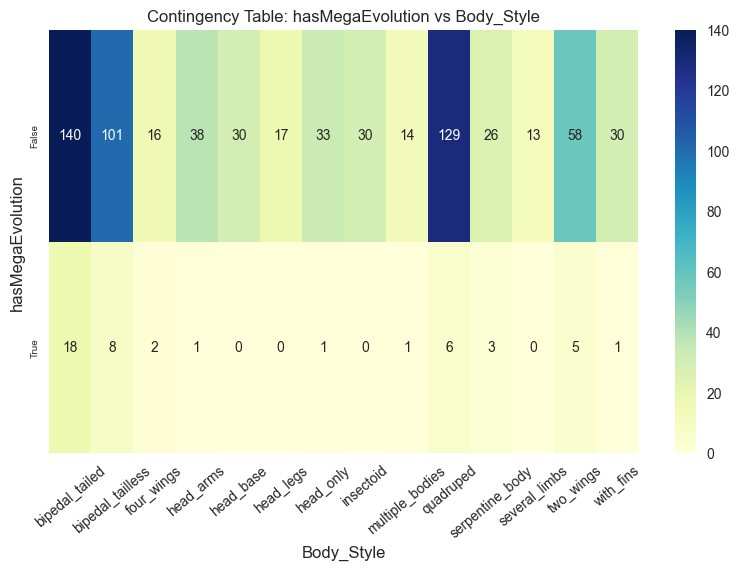

Var 1: hasMegaEvolution,
Var 2: Body_Style,
Chi2: 4.1987621851192545,
P-Value: 0.1720961946,
Cramér's V: 0.156370075136895,
Degrees of Freedom: 13,
Expected Frequencies: [[147.91955617 102.04576976  16.85159501  36.51178918  28.08599168
   15.91539528  31.83079057  28.08599168  14.04299584 126.38696255
   27.14979196  12.17059639  58.98058252  29.0221914 ]
 [ 10.08044383   6.95423024   1.14840499   2.48821082   1.91400832
    1.08460472   2.16920943   1.91400832   0.95700416   8.61303745
    1.85020804   0.82940361   4.01941748   1.9778086 ]]


In [15]:
pos_combs = list(combinations(categorical_columns, 2))

results = []

for col1, col2 in pos_combs:
    
    contingency_table = pd.crosstab(copy_pokemons[col1], copy_pokemons[col2])
    
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    
    cramers_v_value = cramers_v(chi2, contingency_table)
    
    results.append({'Var 1': col1,
                    'Var 2': col2,
                    'Chi2': chi2**0.5,
                    'P-Value': f'{p:.10f}',
                    'Cramér\'s V': cramers_v_value,
                    'Degrees of Freedom': dof,
                    'Expected Frequencies': expected})
    
    plt.figure(figsize=(9.5, 5.5))
    sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu', annot_kws={'fontsize': 10})
    
    plt.title(f'Contingency Table: {col1} vs {col2}')
    plt.xlabel(col2, fontsize=12)
    plt.ylabel(col1, fontsize=12)
    plt.xticks(fontsize=10, rotation=40)  
    plt.yticks(fontsize=7)
    
    plt.show()
    
    print(f'Var 1: {col1},\nVar 2: {col2},\nChi2: { chi2**0.5},\nP-Value: {p:.10f},\nCramér\'s V: {cramers_v_value},\nDegrees of Freedom: {dof},\nExpected Frequencies: {expected}')

### Observo la tasa de captura promedio para cada una de las clases de las columnas categoricas


          Body_Style  Catch_Rate
0          head_legs  157.058824
1          insectoid  156.000000
2          with_fins  127.193548
3          head_only  126.705882
4          head_base  114.600000
5      several_limbs  105.384615
6          quadruped  104.125926
7          head_arms  103.974359
8          two_wings   94.904762
9   bipedal_tailless   90.027523
10   serpentine_body   88.931034
11    bipedal_tailed   83.563291
12   multiple_bodies   76.866667
13        four_wings   57.222222


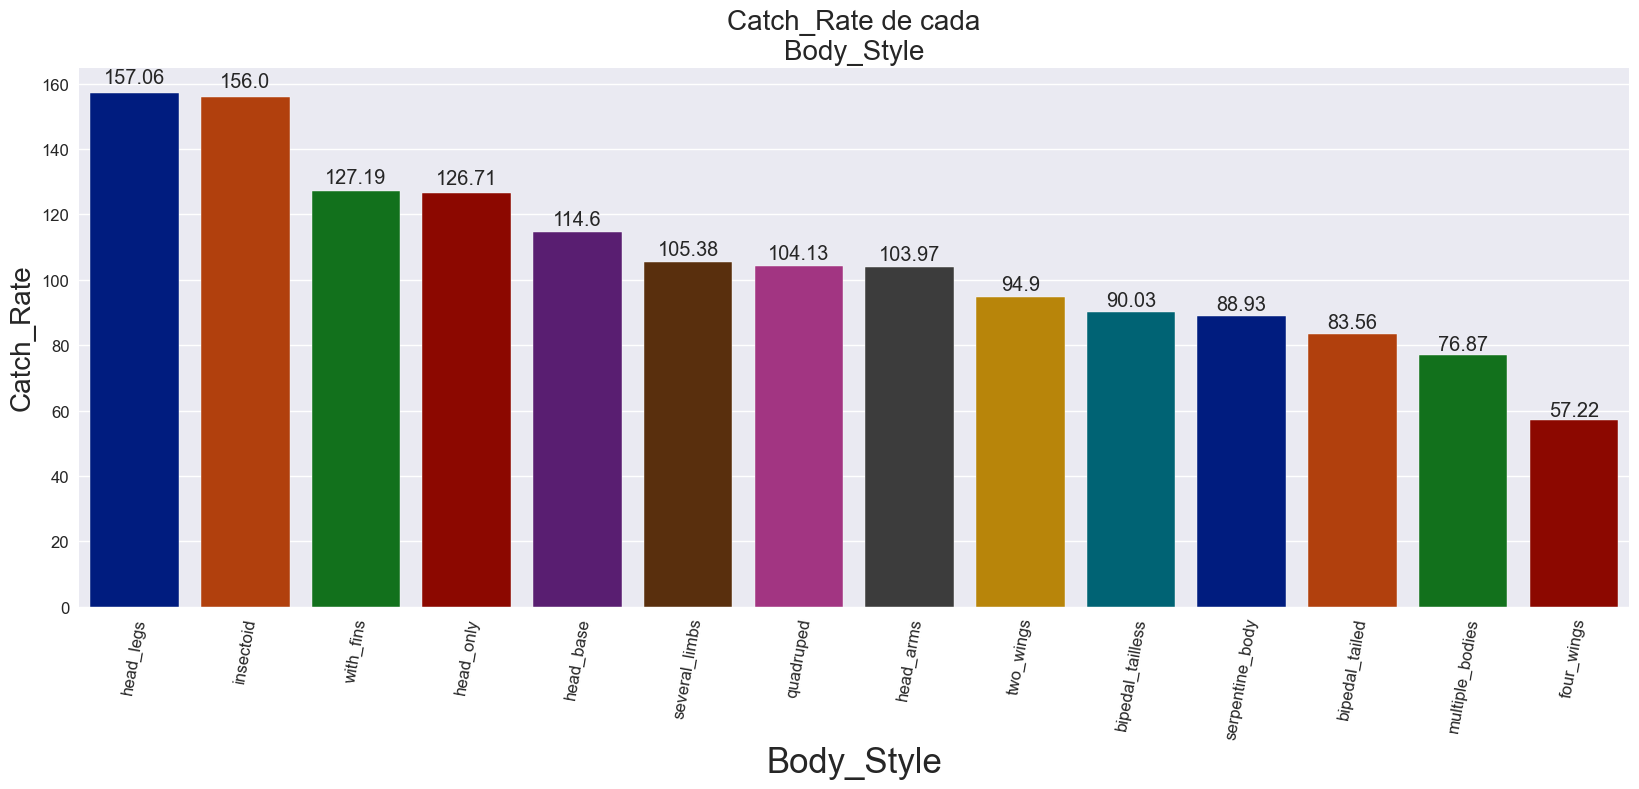

    Color  Catch_Rate
0   Brown  124.054545
1    Pink  108.317073
2   White  107.211538
3  Yellow  102.328125
4    Grey  101.000000
5   Green   98.531646
6  Purple   94.953846
7     Red   92.626667
8   Black   88.875000
9    Blue   84.708955


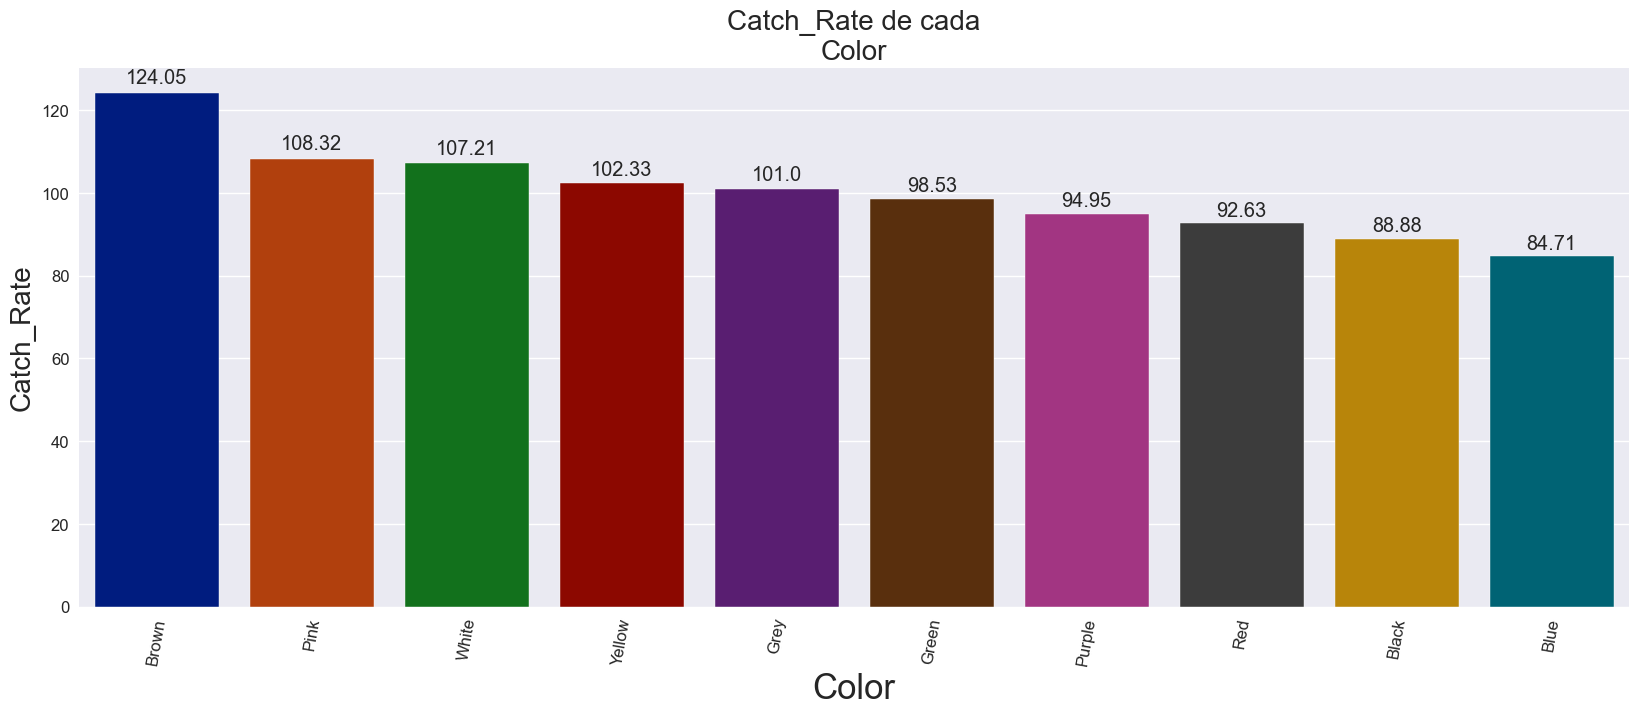

   Generation  Catch_Rate
0           3  113.355556
1           1  106.185430
2           5  103.102564
3           6  100.402778
4           2   91.900000
5           4   78.859813


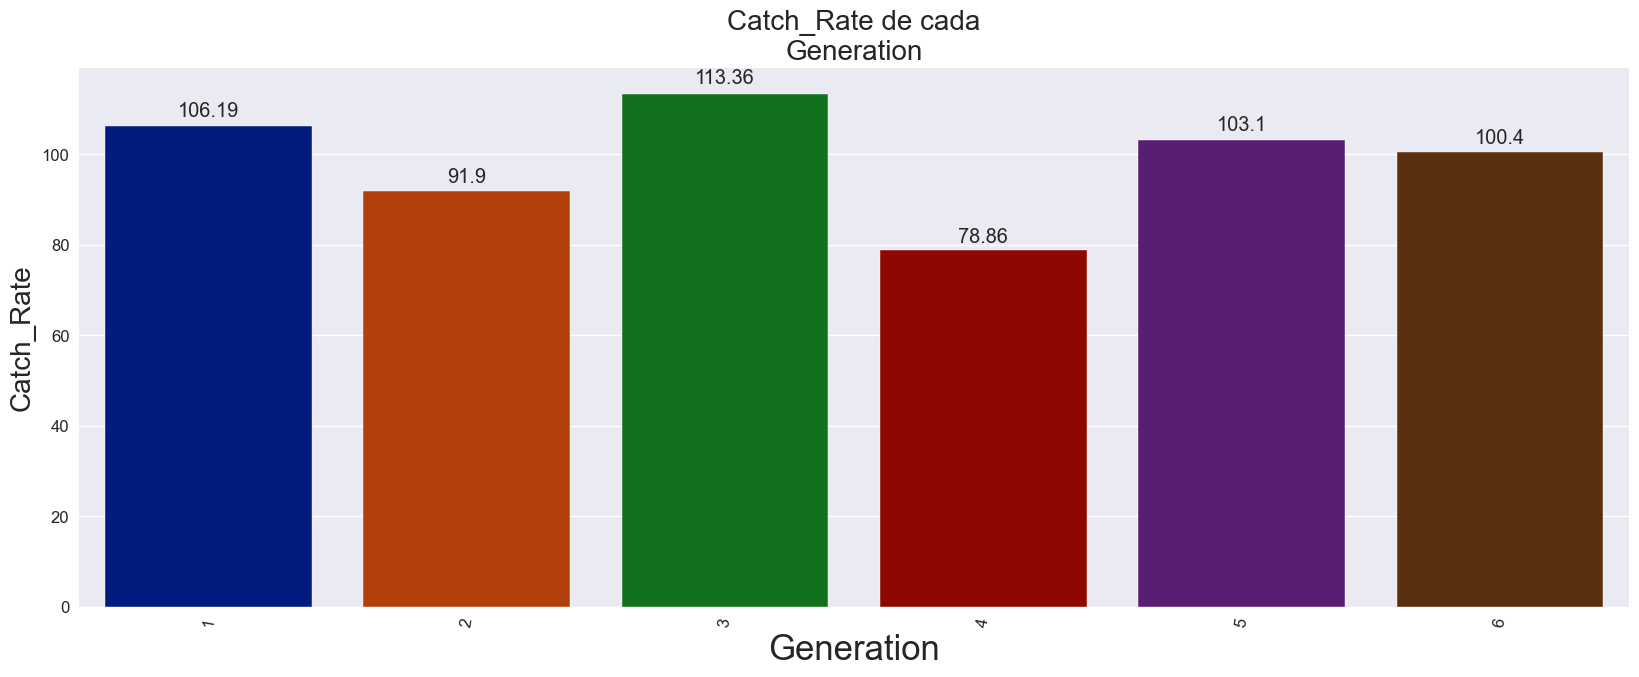

      Type_1  Catch_Rate
0     Poison  131.428571
1     Normal  123.064516
2      Fairy  120.294118
3        Bug  119.492063
4   Electric  109.972222
5     Ground  107.200000
6      Grass  106.333333
7   Fighting  103.000000
8      Water  101.857143
9      Ghost   98.391304
10       Ice   94.173913
11   Psychic   93.765957
12      Dark   86.964286
13    Flying   79.333333
14      Fire   74.787234
15      Rock   69.121951
16     Steel   63.000000
17    Dragon   36.375000


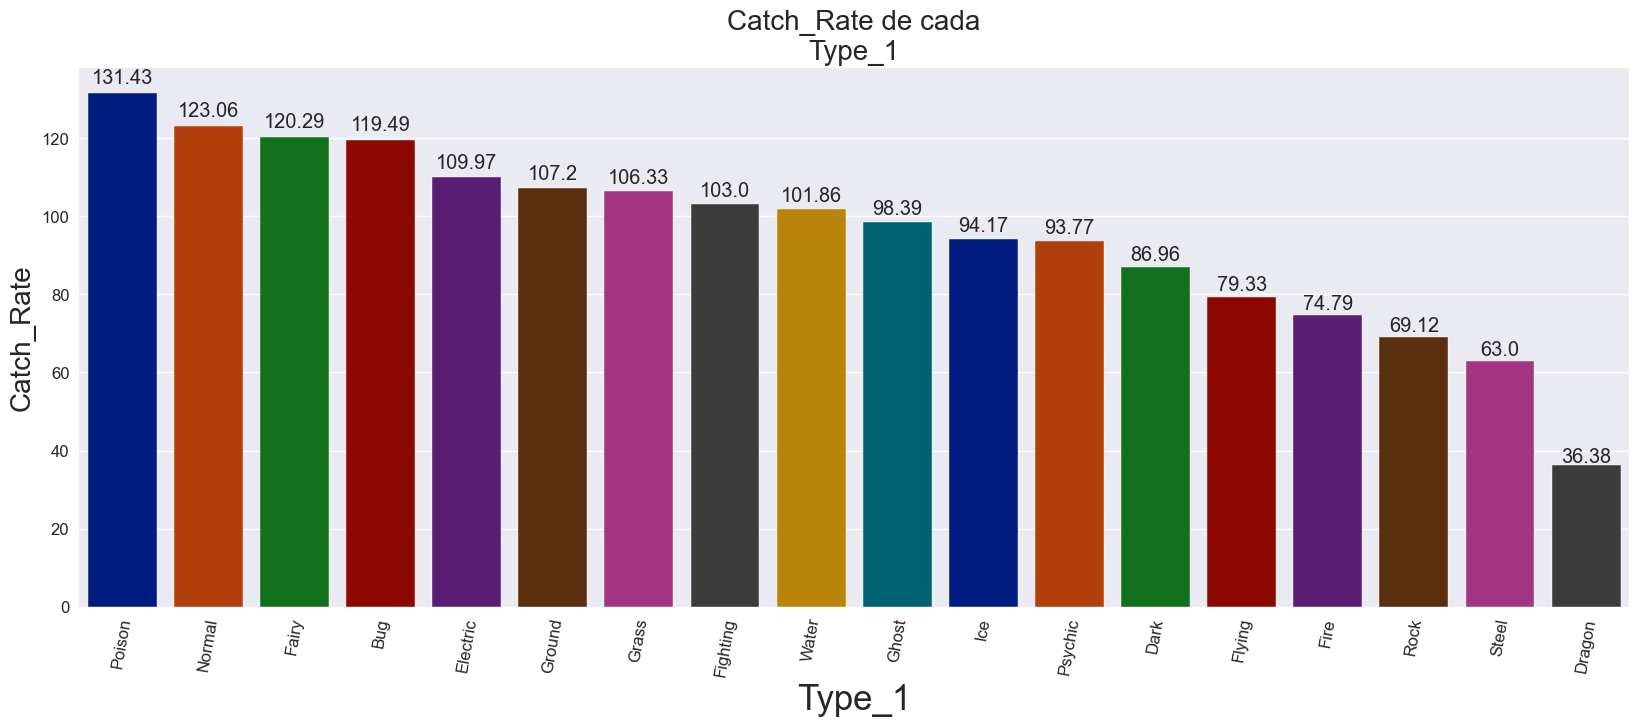

   hasGender  Catch_Rate
0       True  107.451863
1      False   39.987013


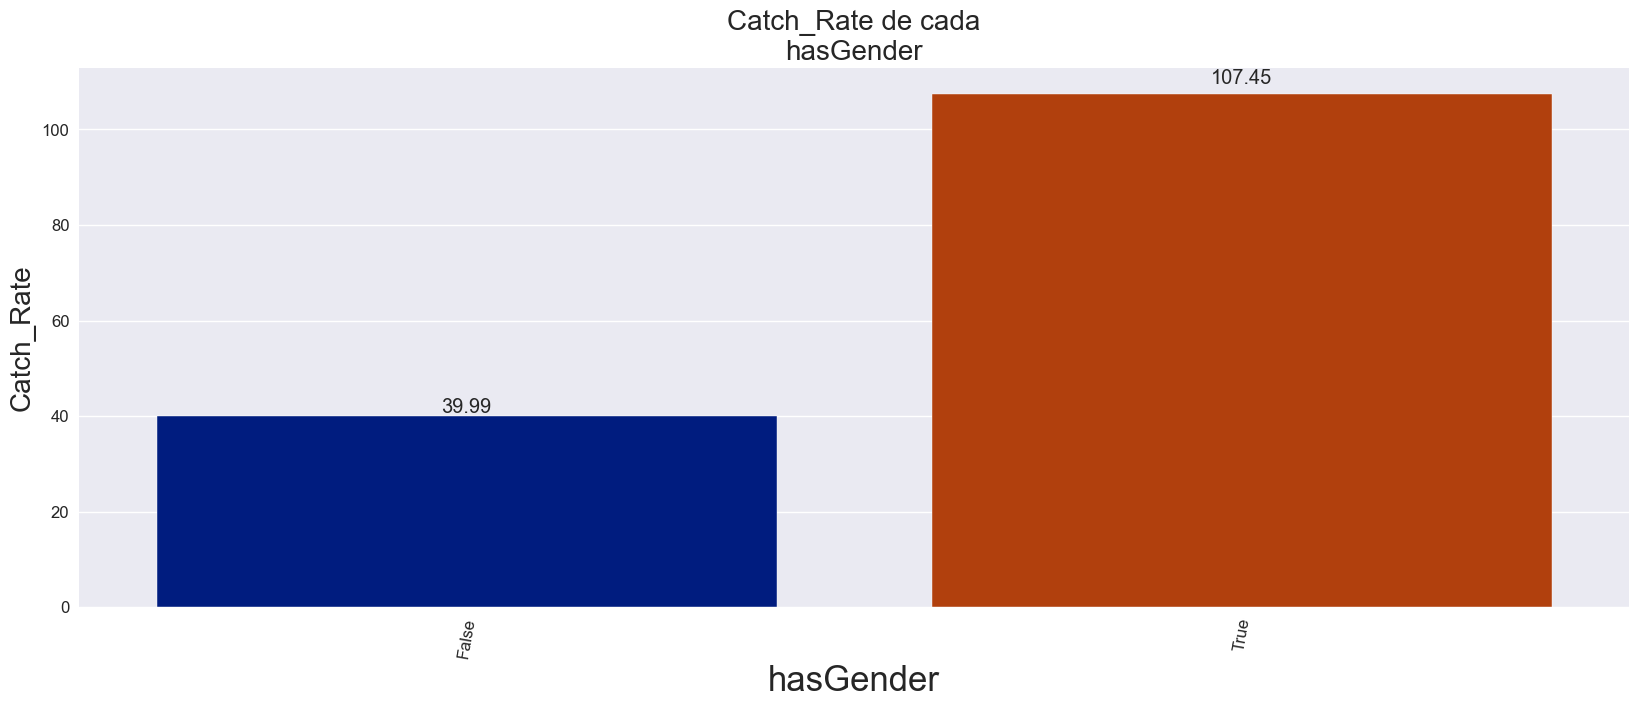

     Egg_Group_1  Catch_Rate
0        Water_2  130.666667
1          Fairy  129.333333
2          Grass  128.703704
3            Bug  119.393939
4         Flying  114.318182
5          Field  112.698225
6        Water_1  108.445946
7      Amorphous  105.853659
8        Water_3  101.071429
9        Mineral  100.847826
10    Human-Like   96.756757
11       Monster   74.121622
12        Dragon   45.000000
13  Undiscovered   41.616438
14         Ditto   35.000000


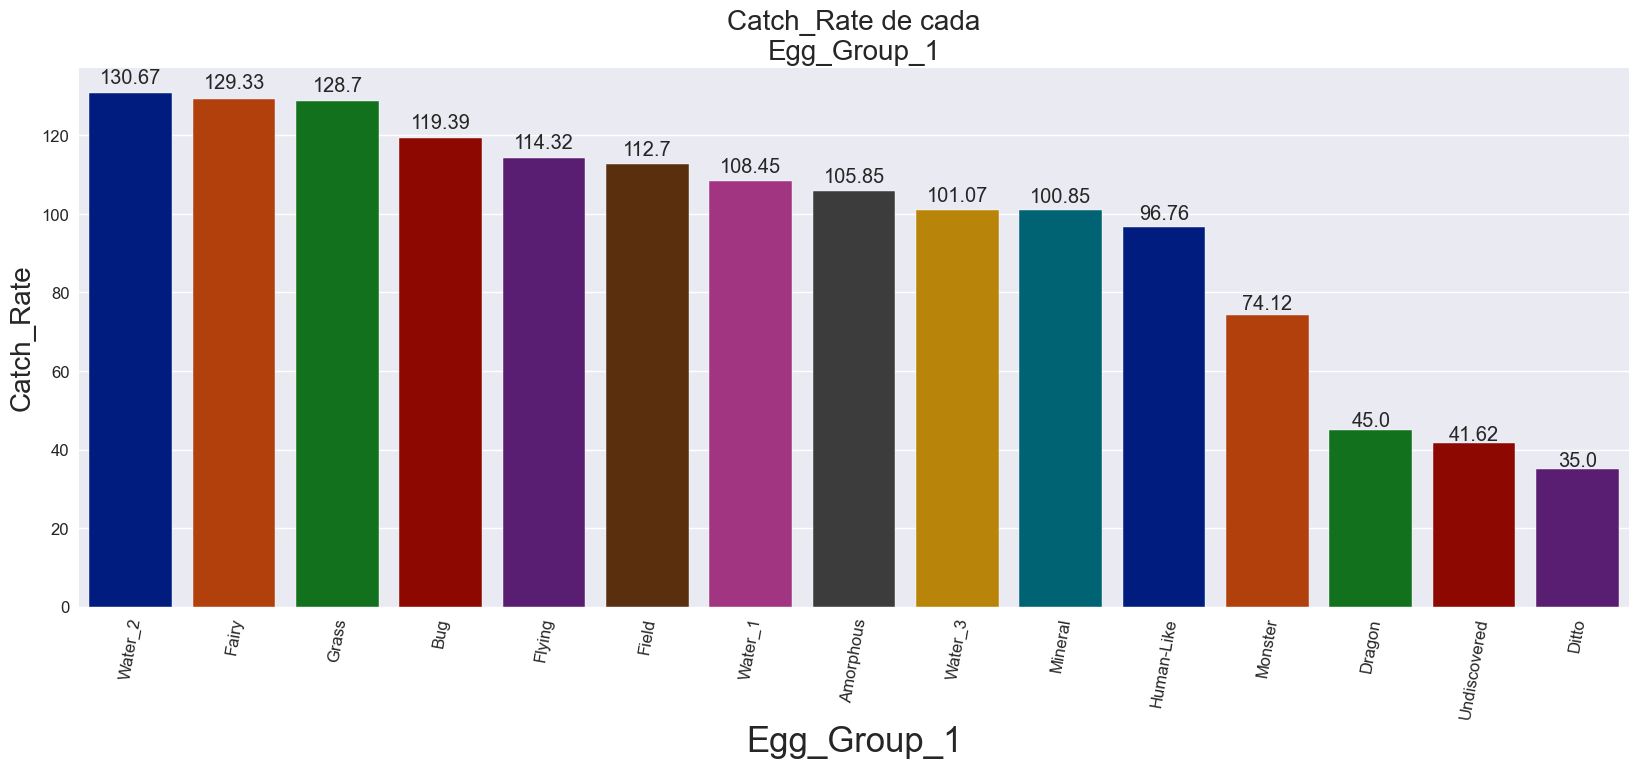

   hasMegaEvolution  Catch_Rate
0             False  103.708148
1              True   49.456522


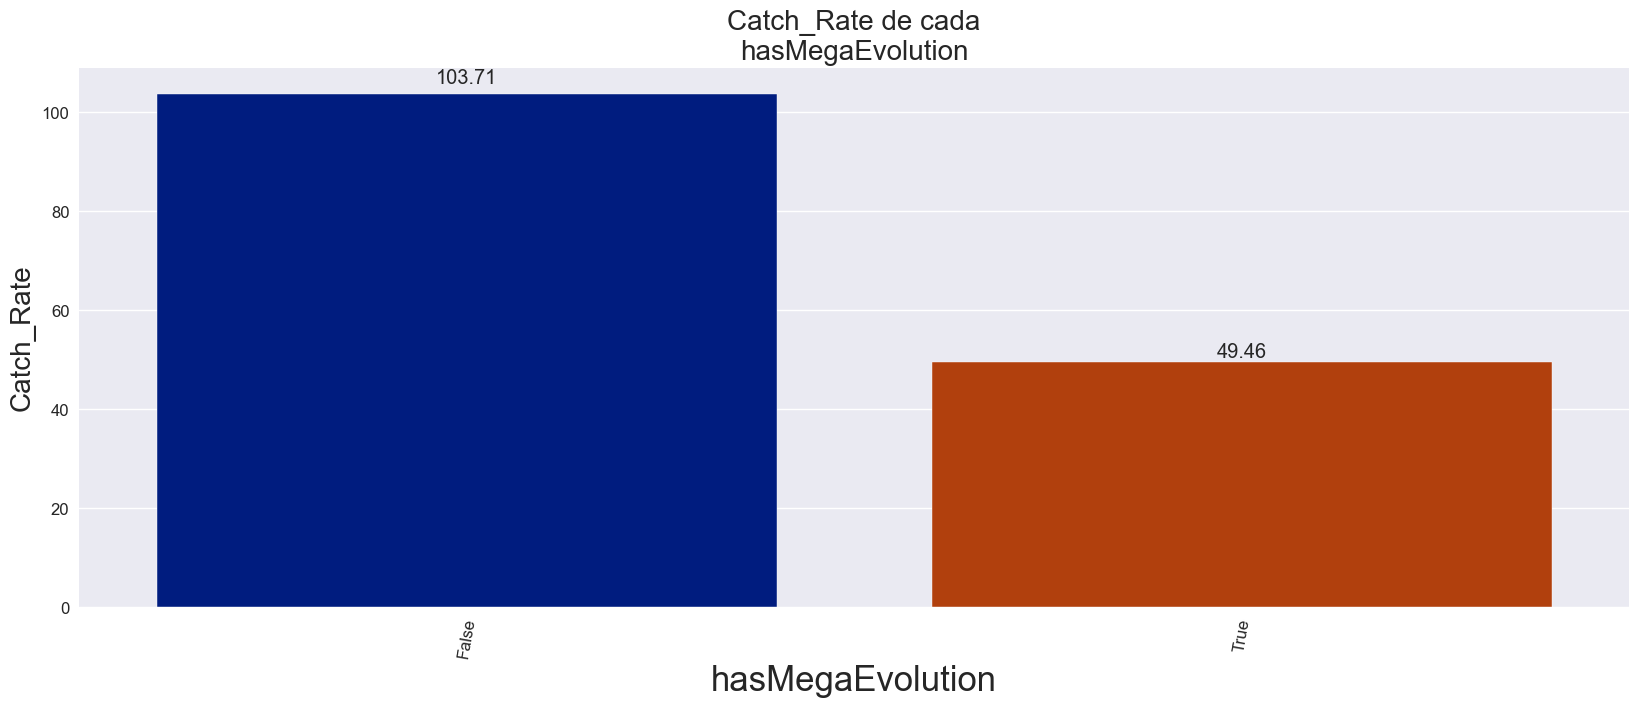

   isLegendary  Catch_Rate
0        False  106.625185
1         True    6.652174


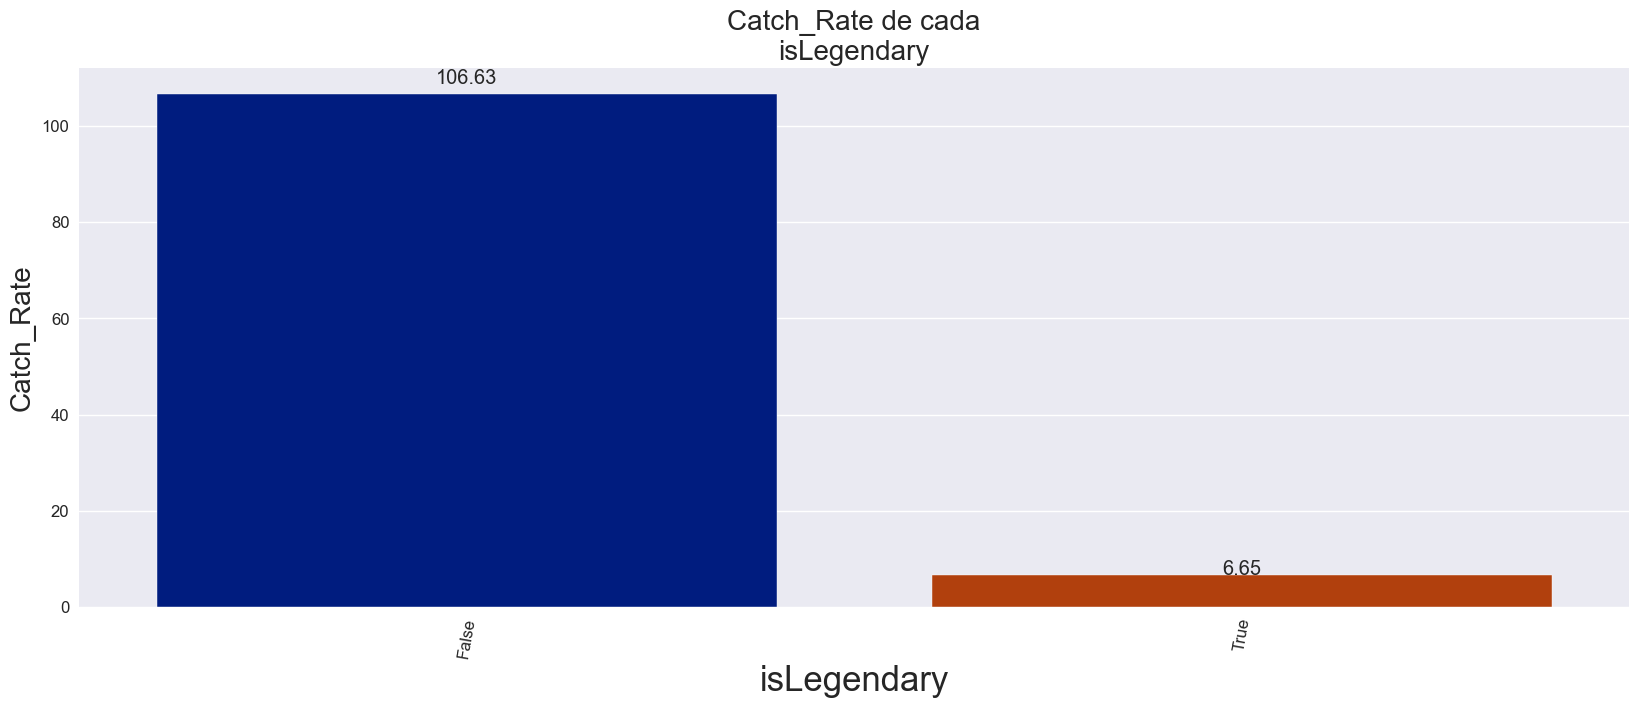

In [16]:
mean_by_class(copy_pokemons, 'Body_Style', 'Catch_Rate')
mean_by_class(copy_pokemons, 'Color', 'Catch_Rate')
mean_by_class(copy_pokemons, 'Generation', 'Catch_Rate')
mean_by_class(copy_pokemons, 'Type_1', 'Catch_Rate')
mean_by_class(copy_pokemons, 'hasGender', 'Catch_Rate')
mean_by_class(copy_pokemons, 'Egg_Group_1', 'Catch_Rate')
mean_by_class(copy_pokemons, 'hasMegaEvolution', 'Catch_Rate')
mean_by_class(copy_pokemons, 'isLegendary', 'Catch_Rate')

### Realizo un kernel density plot y un grafico Q-Q, ademas de calcular la media, la mediana y la moda y hacer la prueba de asimetria y curtosis para determinar si las variables numericas siguen una distribuicion gaussiana

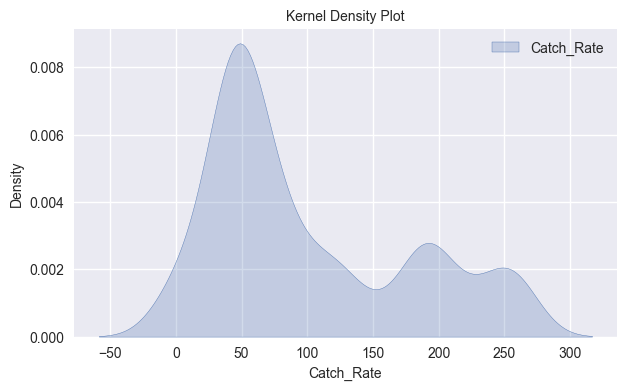

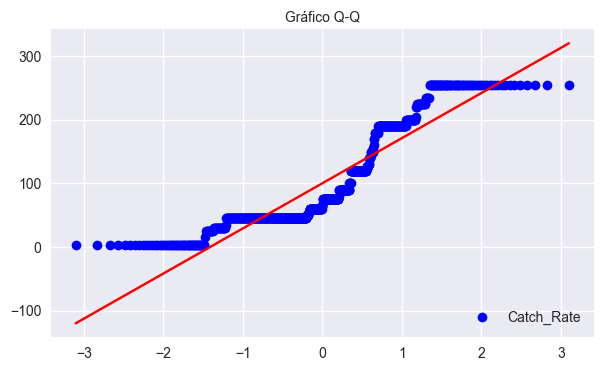

Asimetría: 0.8011369585497614, Kurtosis: -0.6935303995710651
Media: 100.24687933425797, Mediana: 65.0, Moda: 0    45
Name: Catch_Rate, dtype: int64



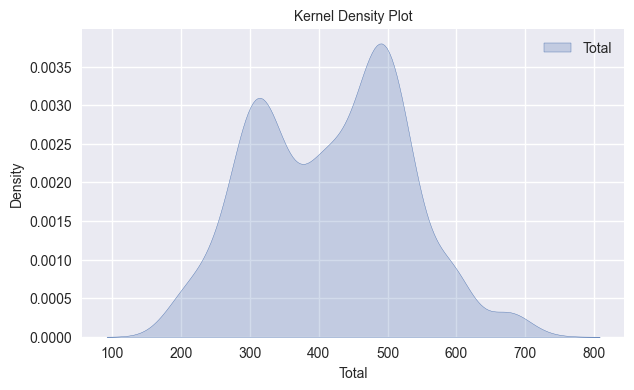

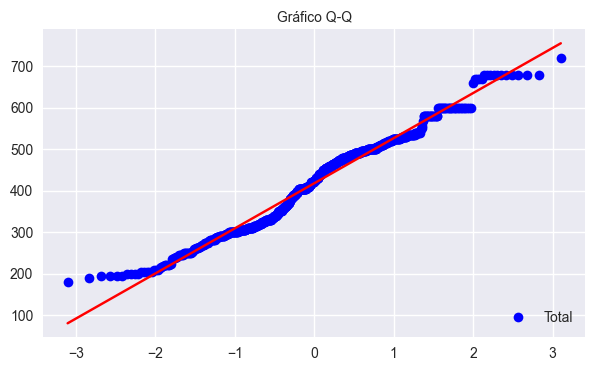

Asimetría: 0.06152167545100133, Kurtosis: -0.6467754391114782
Media: 417.94590846047157, Mediana: 424.0, Moda: 0    405
1    600
Name: Total, dtype: int64



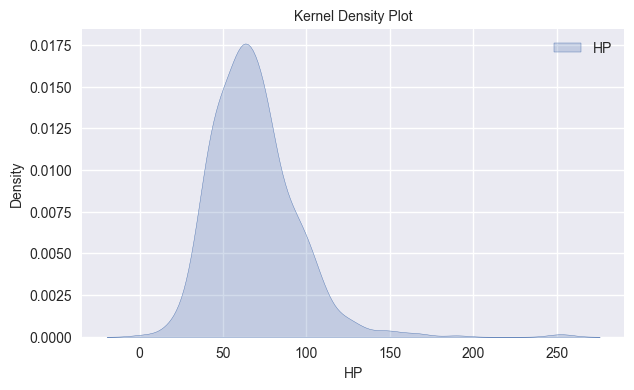

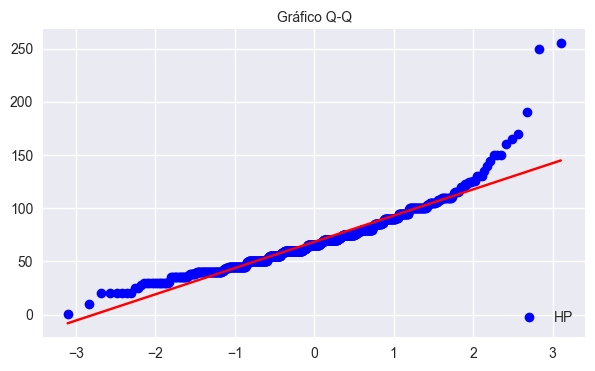

Asimetría: 1.6657339769238528, Kurtosis: 7.718532612079384
Media: 68.38002773925103, Mediana: 65.0, Moda: 0    60
Name: HP, dtype: int64



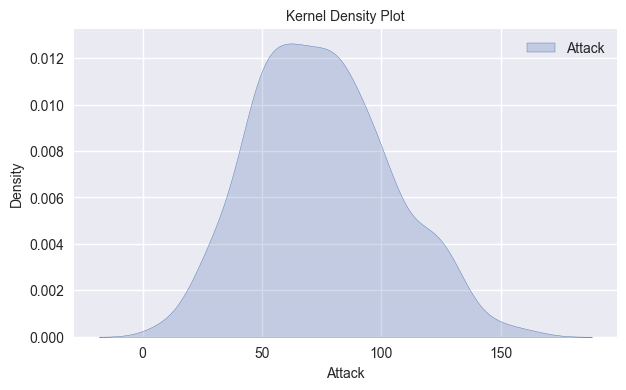

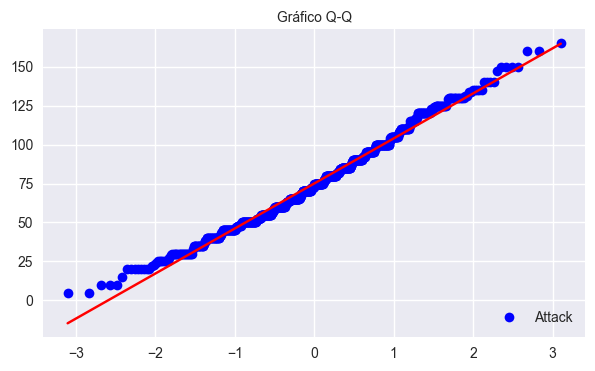

Asimetría: 0.30778074624751023, Kurtosis: -0.2736812014670118
Media: 75.01386962552012, Mediana: 74.0, Moda: 0    50
1    80
Name: Attack, dtype: int64



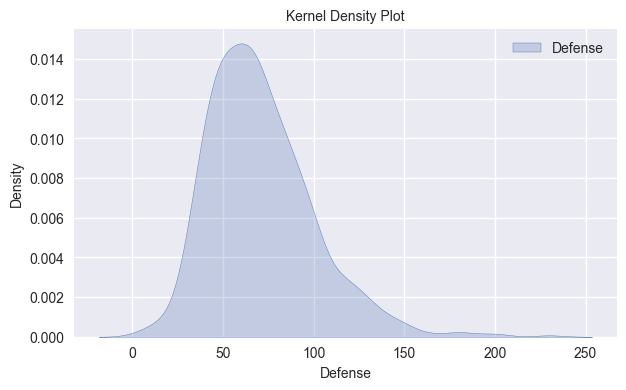

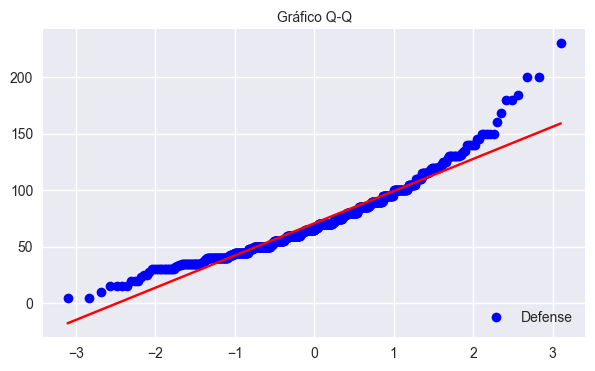

Asimetría: 1.1191361810560871, Kurtosis: 2.4595020727927412
Media: 70.80859916782246, Mediana: 65.0, Moda: 0    50
1    70
Name: Defense, dtype: int64



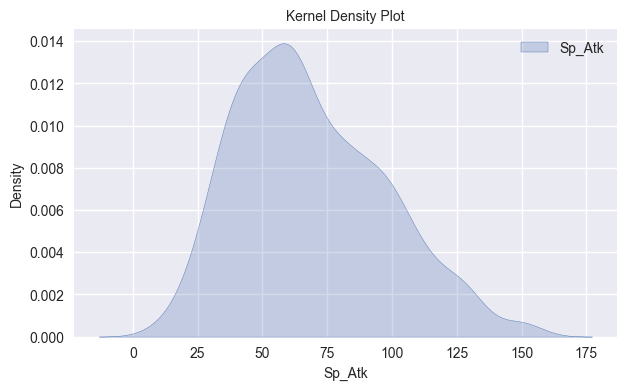

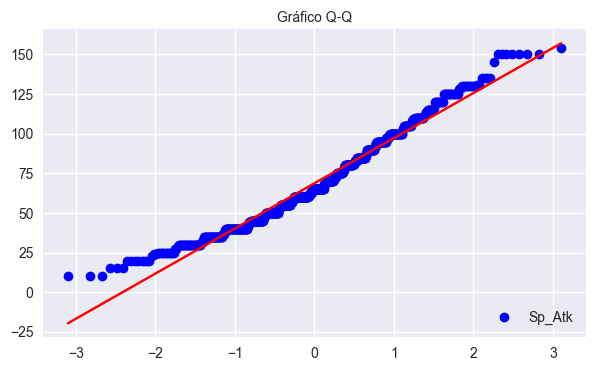

Asimetría: 0.5259997211071494, Kurtosis: -0.2598364588182114
Media: 68.7378640776699, Mediana: 65.0, Moda: 0    60
Name: Sp_Atk, dtype: int64



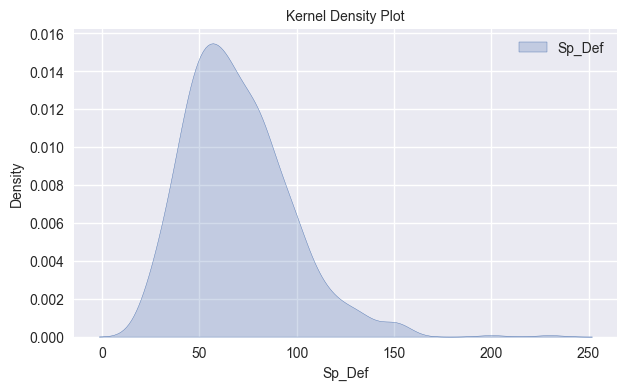

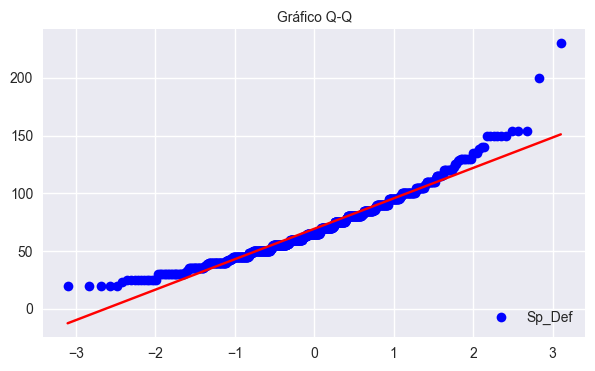

Asimetría: 1.025619523718653, Kurtosis: 2.3668863554290995
Media: 69.29126213592232, Mediana: 65.0, Moda: 0    50
Name: Sp_Def, dtype: int64



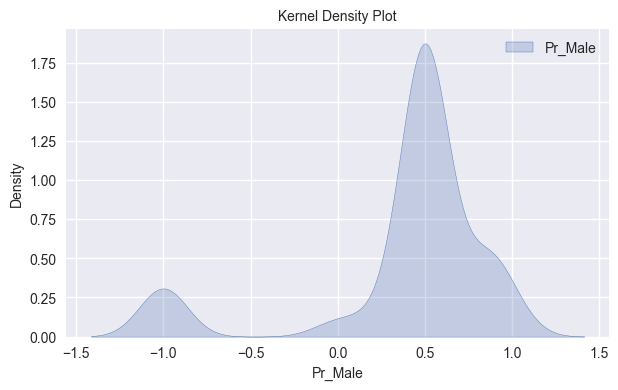

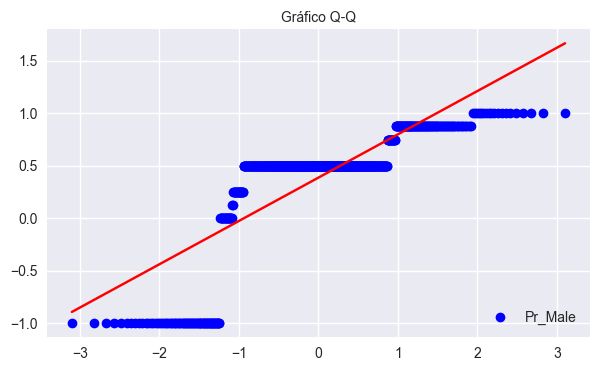

Asimetría: -1.9173177703294677, Kurtosis: 2.7834371965488947
Media: 0.38748266296809986, Mediana: 0.5, Moda: 0    0.5
Name: Pr_Male, dtype: float64



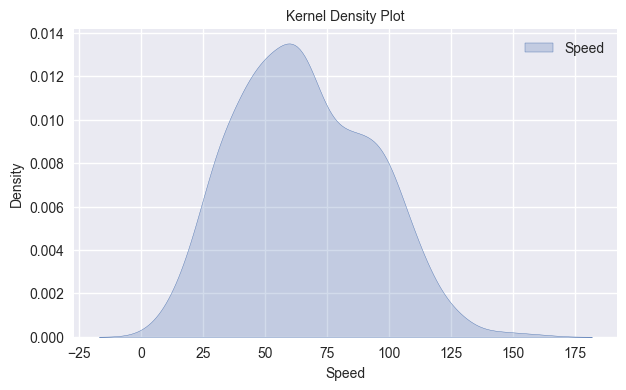

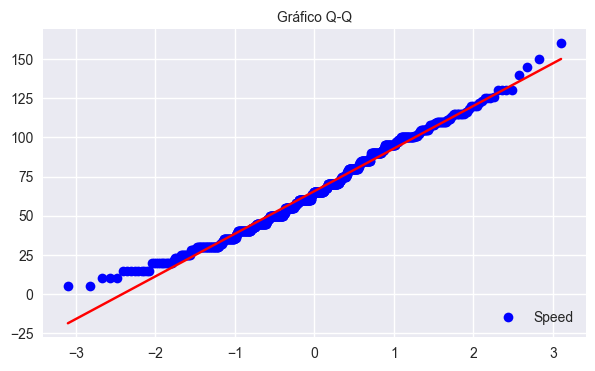

Asimetría: 0.2779904507648011, Kurtosis: -0.45139743298427026
Media: 65.71428571428571, Mediana: 65.0, Moda: 0    50
1    60
Name: Speed, dtype: int64



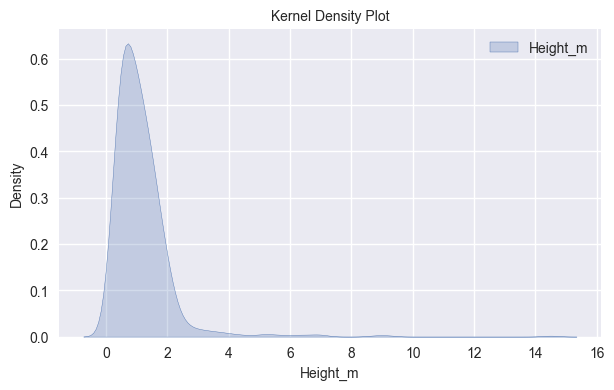

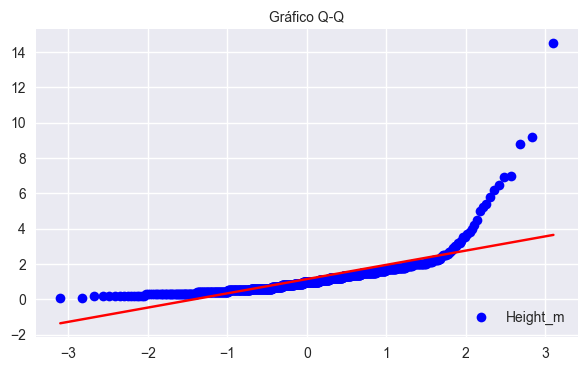

Asimetría: 5.497201391061776, Kurtosis: 49.77391762496644
Media: 1.14497919556172, Mediana: 0.99, Moda: 0    0.61
Name: Height_m, dtype: float64



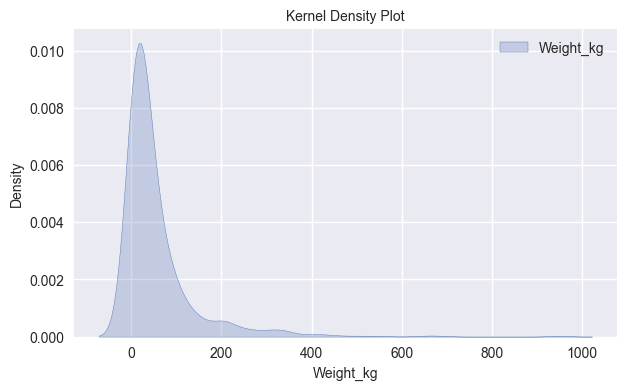

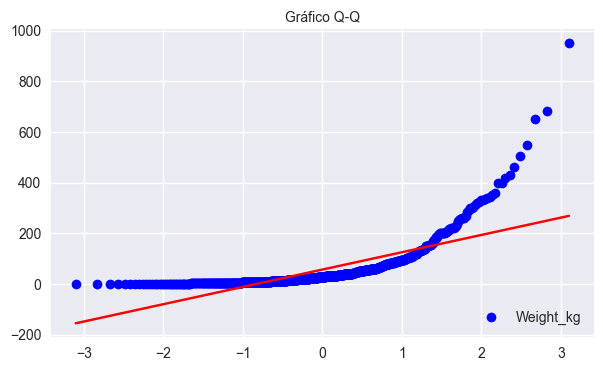

Asimetría: 4.000323865798583, Kurtosis: 23.7098131280065
Media: 56.773370319001394, Mediana: 28.0, Moda: 0    5.0
Name: Weight_kg, dtype: float64



In [17]:
numerical_columns = ['Catch_Rate', 'Total', 'HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Pr_Male','Speed', 'Height_m', 'Weight_kg']

for column in numerical_columns:
    legends = [column]
    data = copy_pokemons[column]
    
    plt.figure(figsize=(7, 4))
    sns.kdeplot(data, fill=True)
    
    plt.xlabel(f'{legends[0]}', fontsize=10)
    plt.ylabel(f'Density', fontsize=10)
    
    plt.title('Kernel Density Plot', fontsize=10)
    plt.legend(legends, fontsize=10)
    
    plt.show()
    
    plt.figure(figsize=(7, 4))
    stats.probplot(data, dist="norm", plot=plt)
    
    plt.xlabel('')
    plt.ylabel('')
    
    plt.legend(legends, fontsize=10, loc='lower right')
    plt.title('Gráfico Q-Q', fontsize=10)
    
    plt.show()
    
    mean = data.mean()
    median = data.median()
    mode = data.mode()
    asymmetry = stats.skew(data)
    kurt = stats.kurtosis(data)
    
    print(f'Asimetría: {asymmetry}, Kurtosis: {kurt}')
    print(f"Media: {mean}, Mediana: {median}, Moda: {mode}\n")

### Hago un grafico boxplot para graficar y visualizar outliers dentro de las columnas numericas

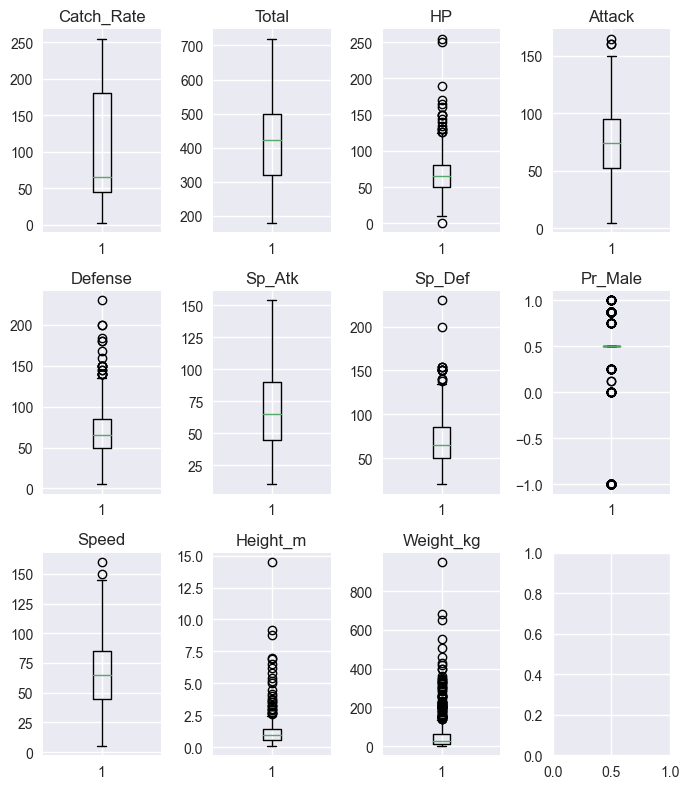

In [18]:
ig, axes = plt.subplots(3, 4, figsize=(7, 8))  

axes = axes.flatten()

for i, column in enumerate(numerical_columns):
    axes[i].boxplot(copy_pokemons[column])
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

### Utilizo la funcion creada anteriormente para comprobar la correlacion existente entre las variables numericas

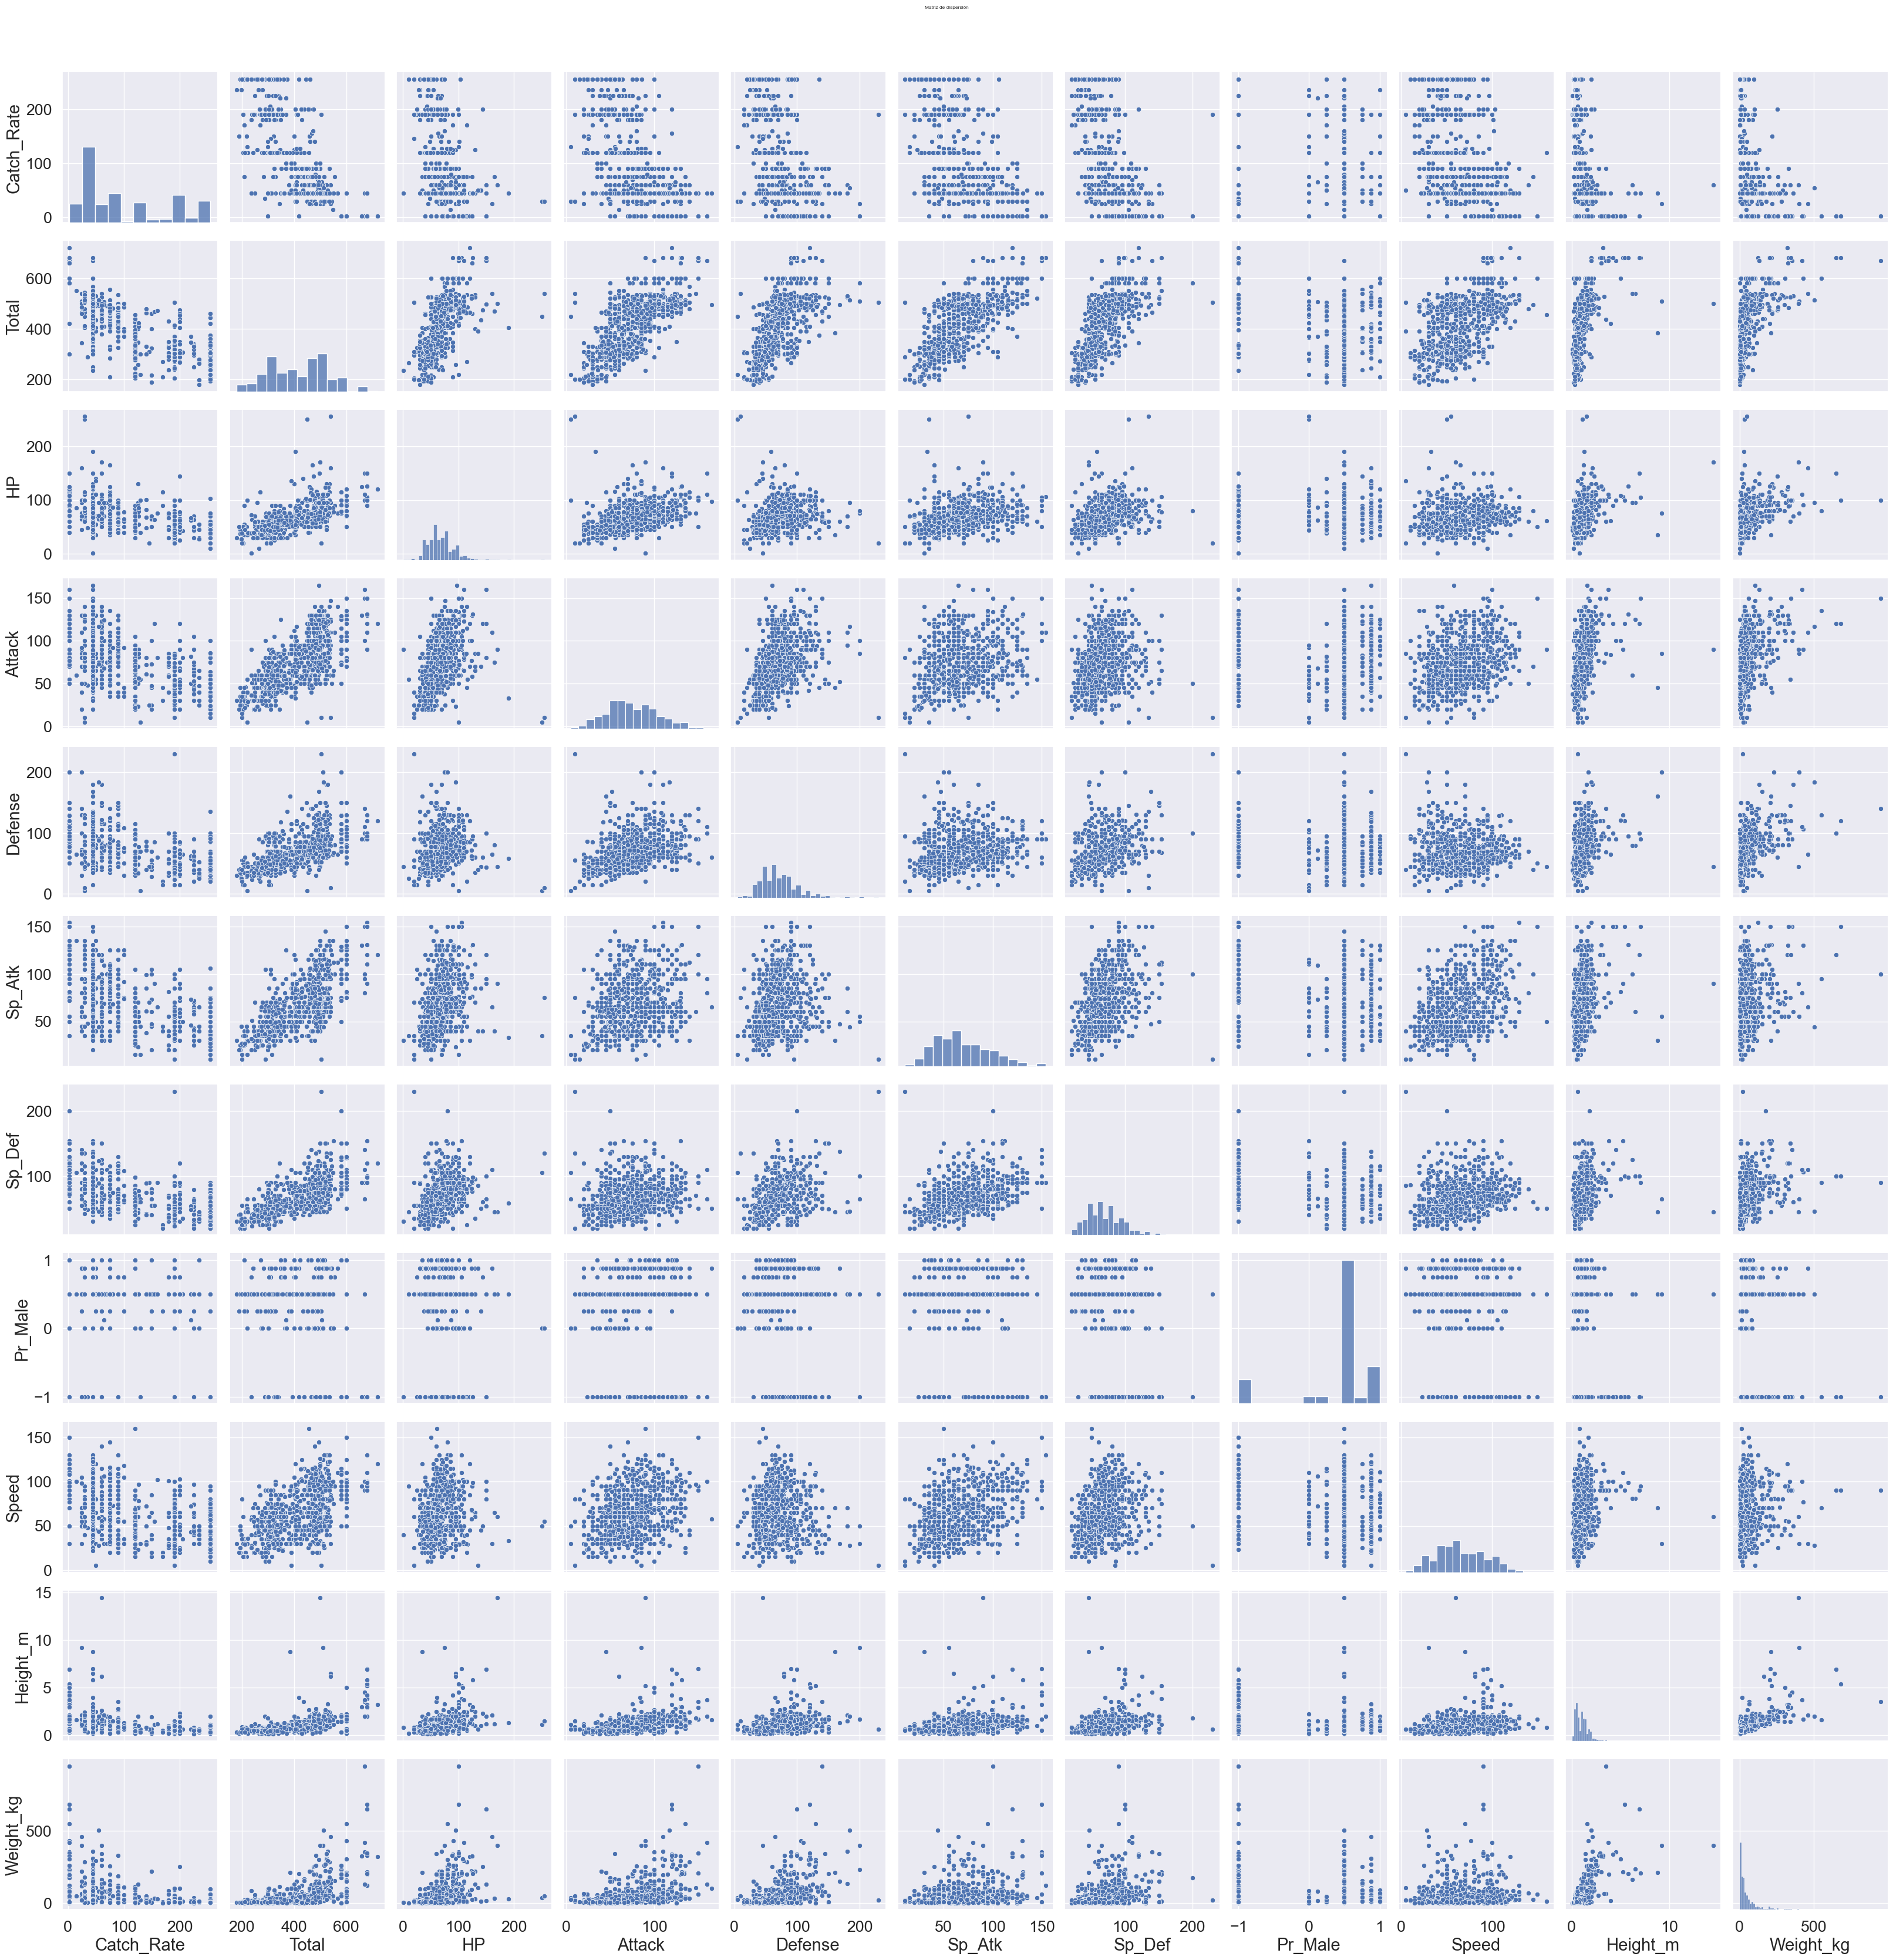

Matriz de correlaciones:
            Catch_Rate     Total        HP    Attack   Defense    Sp_Atk  \
Catch_Rate    1.000000 -0.738280 -0.478725 -0.525106 -0.436558 -0.539114   
Total        -0.738280  1.000000  0.642628  0.704164  0.605831  0.723737   
HP           -0.478725  0.642628  1.000000  0.431680  0.228834  0.368640   
Attack       -0.525106  0.704164  0.431680  1.000000  0.433233  0.335205   
Defense      -0.436558  0.605831  0.228834  0.433233  1.000000  0.202519   
Sp_Atk       -0.539114  0.723737  0.368640  0.335205  0.202519  1.000000   
Sp_Def       -0.513014  0.706501  0.376006  0.207211  0.483986  0.492861   
Pr_Male       0.167560 -0.323788 -0.166971 -0.111495 -0.229449 -0.279671   
Speed        -0.410557  0.548890  0.170031  0.335013 -0.008663  0.443106   
Height_m     -0.382862  0.526813  0.442872  0.408590  0.354205  0.330579   
Weight_kg    -0.367798  0.535966  0.431320  0.469395  0.476983  0.285048   

              Sp_Def   Pr_Male     Speed  Height_m  Weight_kg 

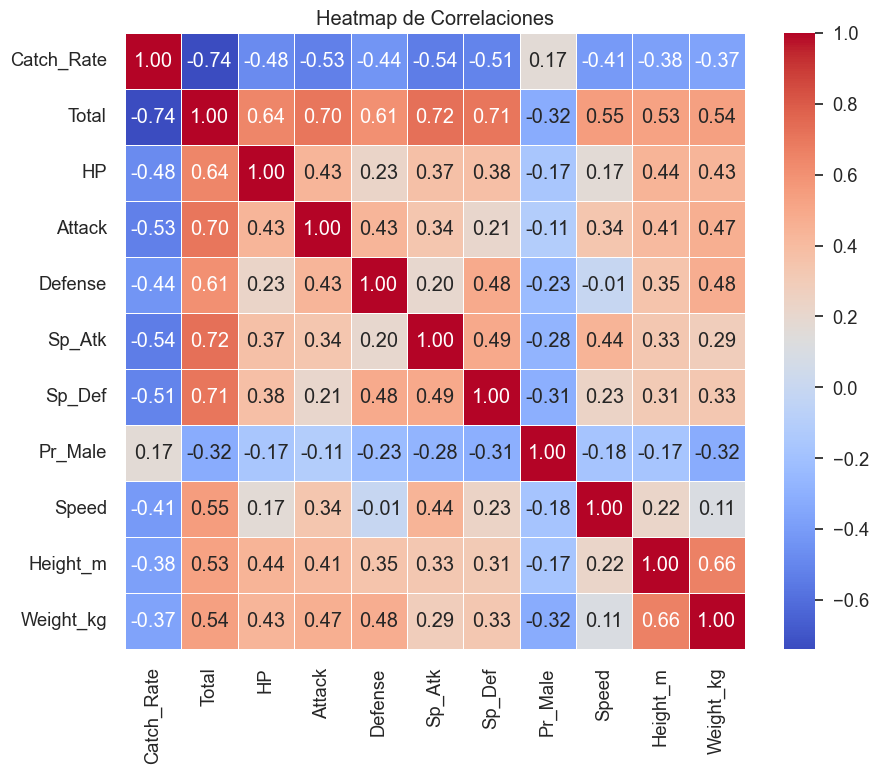

In [19]:
df = copy_pokemons[numerical_columns]
pr_correlation(df)

### Separo mi variable objetivo del resto del dataset y visualizo su distribuicion 

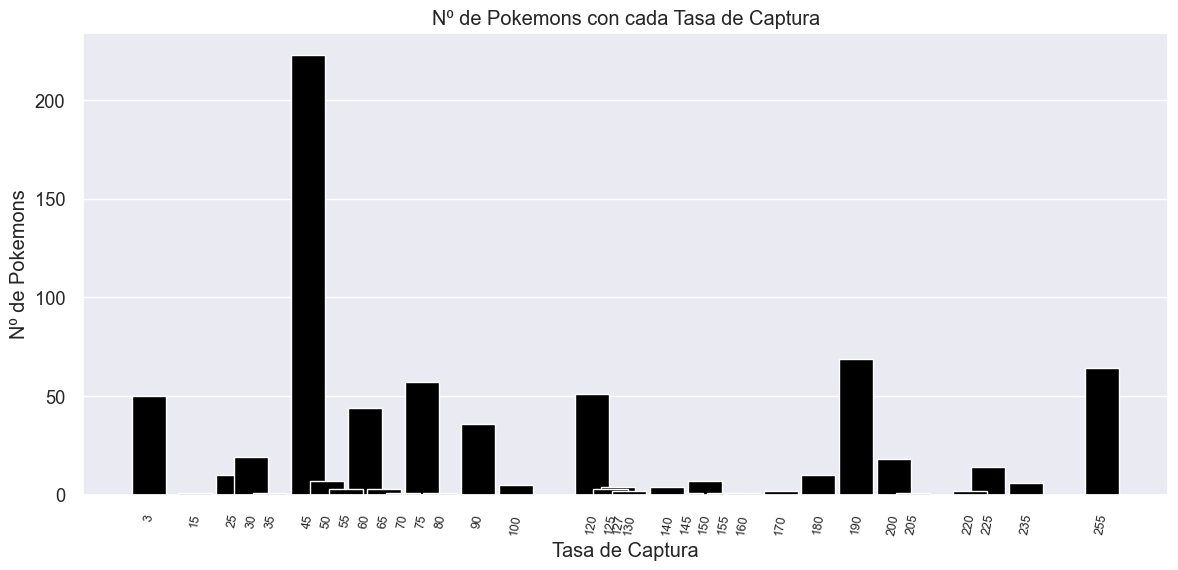

In [20]:
X = copy_pokemons.drop(['Catch_Rate'], axis=1)
y = copy_pokemons['Catch_Rate']

plt.figure(figsize=(14, 6))
plt.bar(Counter(copy_pokemons['Catch_Rate']).keys(), Counter(copy_pokemons['Catch_Rate']).values(), color='black', width=9)

plt.xticks(list(Counter(copy_pokemons['Catch_Rate']).keys()), fontsize=9, horizontalalignment = 'center', rotation = 80)
plt.xlabel('Tasa de Captura')
plt.ylabel('Nº de Pokemons')
plt.title('Nº de Pokemons con cada Tasa de Captura')

plt.grid(axis='x')
plt.show()

### Mapeo las variables categoricas sustituyendo los datos por otros de tipo numerico 

In [21]:
maping = {False: 0, True: 1}

X['isLegendary'] = X['isLegendary'].map(maping).astype(int)
X['hasGender'] = X['hasGender'].map(maping).astype(int)
X['hasMegaEvolution'] = X['hasMegaEvolution'].map(maping).astype(int)
X['Total+Catch_Rate'] = X.Total + y

mapear(X, list(X.columns))

X

Type_1  Total   HP  Attack  Defense  Sp_Atk  Sp_Def  Speed  Generation  \
0         1    318   45      49       49      65      65     45           1   
1         1    405   60      62       63      80      80     60           1   
2         1    525   80      82       83     100     100     80           1   
3         2    309   39      52       43      60      50     65           1   
4         2    405   58      64       58      80      65     80           1   
..      ...    ...  ...     ...      ...     ...     ...    ...         ...   
716      16    680  126     131       95     131      98     99           6   
717      15    600  108     100      121      81      95     95           6   
718      12    600   50     100      150     100     150     50           6   
719      11    600   80     110       60     150     130     70           6   
720       2    600   80     110      120     130      90     70           6   

     isLegendary  Color  hasGender  Pr_Male  Egg_Group_1  hasMegaEvolution  \
0              0      1          1    0.875            1                 0   
1              0      1          1    0.875            1                 0   
2              0      1          1    0.875            1                 1   
3              0      2          1    0.875            1                 0   
4              0      2          1    0.875            1                 0   
..           ...    ...        ...      ...          ...               ...   
716            1      2          0   -1.000            5                 0   
717            1      1          0   -1.000            5                 0   
718            1      8          0   -1.000            5                 1   
719            1      7          0   -1.000            5                 0   
720            1      5          0   -1.000            5                 0   

     Height_m  Weight_kg  Body_Style  Total+Catch_Rate  
0        0.71        6.9           1               363  
1        0.99       13.0           1               450  
2        2.01      100.0           1               570  
3        0.61        8.5           2               354  
4        1.09       19.0           2               450  
..        ...        ...         ...               ...  
716      5.79      203.0           6               725  
717      5.00      305.0           4               603  
718      0.71        8.8          12               603  
719      0.51        9.0          14               603  
720      1.70      195.0           1               603  

[721 rows x 19 columns]

### Ya que el dataset cuenta con algunas clases con muy pocas muestras, lo que hace que este desbalanceado, creo nuevas muestras de manera sintetica con la libreria imblearn

In [22]:
class_counts = Counter(y)

print(sorted(class_counts.items()), '\n')

min_samples = 2
filtered_indices = y.index[y.map(y.value_counts()) >= min_samples]

X_filtered = X.loc[filtered_indices]
y_filtered = y.loc[filtered_indices]

min_samples = min(class_counts.values())
n_neighbors = max(1, min(5, min_samples - 1))

smote = SMOTE(k_neighbors=n_neighbors)

smt = SMOTETomek(sampling_strategy='auto', random_state=42, smote=smote)

X, y = smt.fit_resample(X_filtered, y_filtered)

print('-'*40, '\n')
print(sorted(Counter(y).items()))

[(3, 50), (15, 1), (25, 10), (30, 19), (35, 1), (45, 223), (50, 7), (55, 3), (60, 44), (65, 3), (70, 1), (75, 57), (80, 1), (90, 36), (100, 5), (120, 51), (125, 3), (127, 4), (130, 2), (140, 4), (145, 1), (150, 7), (155, 1), (160, 1), (170, 2), (180, 10), (190, 69), (200, 18), (205, 1), (220, 2), (225, 14), (235, 6), (255, 64)] 

---------------------------------------- 

[(3, 223), (25, 223), (30, 223), (45, 223), (50, 223), (55, 223), (60, 223), (65, 223), (75, 223), (90, 223), (100, 223), (120, 223), (125, 223), (127, 223), (130, 223), (140, 223), (150, 223), (170, 223), (180, 223), (190, 223), (200, 223), (220, 223), (225, 223), (235, 223), (255, 223)]


In [23]:
X

Type_1  Total  HP  Attack  Defense  Sp_Atk  Sp_Def  Speed  Generation  \
0          1    318  45      49       49      65      65     45           1   
1          1    405  60      62       63      80      80     60           1   
2          1    525  80      82       83     100     100     80           1   
3          2    309  39      52       43      60      50     65           1   
4          2    405  58      64       58      80      65     80           1   
...      ...    ...  ..     ...      ...     ...     ...    ...         ...   
5570       5    251  54      47       39      35      39     34           4   
5571       4    196  43      42       36      21      28     23           3   
5572       4    196  43      42       36      21      28     23           3   
5573       9    365  31      51      118      54      78     30           3   
5574       3    200  20      14       26      10      48     80           2   

      isLegendary  Color  hasGender  Pr_Male  Egg_Group_1  hasMegaEvolution  \
0               0      1          1    0.875            1                 0   
1               0      1          1    0.875            1                 0   
2               0      1          1    0.875            1                 1   
3               0      2          1    0.875            1                 0   
4               0      2          1    0.875            1                 0   
...           ...    ...        ...      ...          ...               ...   
5570            0      5          1    0.500            6                 0   
5571            0      3          1    0.500            2                 0   
5572            0      3          1    0.500            2                 0   
5573            0      7          1    0.500           10                 0   
5574            0      4          1    0.500            8                 0   

      Height_m   Weight_kg  Body_Style  Total+Catch_Rate  
0     0.710000    6.900000           1               363  
1     0.990000   13.000000           1               450  
2     2.010000  100.000000           1               570  
3     0.610000    8.500000           2               354  
4     1.090000   19.000000           2               450  
...        ...         ...         ...               ...  
5570  0.510000   17.565602           1               506  
5571  0.300000    3.354094           3               451  
5572  0.300000    3.371760           3               451  
5573  0.799582   82.390353           9               620  
5574  0.665296    7.913460          13               455  

[5575 rows x 19 columns]

### Normalizo y hago un escalado de los datos, ademas de mapear mi variable objetivo

In [24]:
scaler = StandardScaler()
normalize = MinMaxScaler()
encoder = LabelEncoder()

y = encoder.fit_transform(y)

X[['Total', 'HP', 'Attack', 'Defense', 'Sp_Atk',
   'Sp_Def', 'Speed', 'Total+Catch_Rate']] = scaler.fit_transform(X[['Total', 'HP', 'Attack', 'Defense', 'Sp_Atk',
                                                                 'Sp_Def', 'Speed', 'Total+Catch_Rate']])
X[['Pr_Male','Height_m', 'Weight_kg']] = normalize.fit_transform(X[['Pr_Male','Height_m', 'Weight_kg']])


### Divido mis datos en set de entrenamiento y test

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Utilizo mi funcion para testear las diferentes opciones de modelos que he escogido

In [26]:
test_models(X_train, y_train, X_test, y_test)

Modelo: LogisticRegression() 

------------------------------------------------------------ 

Cross-Validation
0.8002242152466368

Prediccion: 
[15, 14, 0, 14, 2, 23, 18, 20, 24, 23, 8, 15, 18, 13, 21, 24, 16, 21, 7, 18, 3, 5, 22, 20, 11, 11, 18, 16, 10, 0, 9, 11, 23, 22, 2, 1, 12, 2, 20, 1, 23, 1, 5, 21, 14, 22, 10, 5, 22, 14, 9, 23, 15, 24, 17, 1, 12, 9, 6, 18, 15, 5, 13, 16, 13, 0, 23, 5, 11, 2, 15, 15, 8, 1, 19, 14, 8, 18, 20, 23, 12, 17, 5, 9, 23, 2, 13, 1, 24, 2, 3, 17, 18, 11, 5, 4, 20, 24, 9, 21, 20, 2, 2, 20, 16, 10, 10, 8, 8, 9, 9, 17, 21, 5, 17, 18, 1, 19, 24, 7, 21, 9, 3, 1, 18, 15, 7, 17, 4, 0, 14, 18, 24, 7, 8, 6, 5, 16, 0, 2, 12, 12, 1, 10, 20, 19, 16, 14, 6, 10]

\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/ 

Valores Reales: 
[15, 14, 0, 14, 2, 23, 18, 18, 24, 23, 8, 15, 18, 13, 21, 24, 11, 21, 7, 18, 6, 5, 22, 20, 11, 11, 18, 16, 10, 0, 9, 11, 19, 22, 0, 1, 12, 2, 20, 1, 19, 1, 5, 21, 14, 22, 10, 5, 22, 14, 6, 23,

Modelo: LinearSVC() 

------------------------------------------------------------ 

Cross-Validation
0.751019411856482

Prediccion: 
[11, 14, 0, 14, 3, 23, 18, 18, 22, 23, 4, 15, 20, 13, 21, 24, 3, 21, 7, 18, 7, 5, 22, 15, 7, 16, 18, 16, 10, 0, 4, 9, 11, 22, 0, 1, 12, 2, 17, 2, 24, 1, 5, 17, 14, 18, 10, 5, 22, 15, 7, 23, 17, 3, 17, 1, 12, 6, 6, 18, 15, 5, 14, 16, 13, 0, 23, 5, 3, 2, 7, 15, 3, 1, 3, 14, 8, 22, 19, 18, 12, 21, 5, 7, 21, 1, 13, 1, 15, 3, 3, 17, 18, 11, 5, 4, 19, 24, 6, 21, 21, 4, 2, 18, 16, 10, 10, 3, 8, 6, 15, 17, 21, 5, 17, 20, 1, 15, 24, 6, 21, 9, 2, 2, 13, 15, 7, 17, 4, 0, 14, 18, 20, 3, 9, 4, 5, 17, 0, 2, 12, 12, 1, 10, 21, 19, 8, 14, 3, 10]

\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/ 

Valores Reales: 
[15, 14, 0, 14, 3, 23, 18, 18, 22, 23, 8, 15, 18, 13, 21, 24, 6, 21, 7, 18, 3, 5, 22, 20, 11, 11, 18, 16, 10, 0, 3, 11, 11, 22, 0, 1, 12, 2, 17, 2, 24, 1, 5, 17, 14, 18, 10, 5, 22, 15, 6, 23, 17, 6, 17, 1, 12,

### Tras haber elegido el modelo mas optimo, hago un GridsearchCV para saber cuales son los mejores parametros con los que equipar al modelo 

In [27]:
estimator = ExtraTreesClassifier(random_state=42)

param_grid = {'n_estimators': [100, 150, 200],
              'criterion': ['gini', 'entropy', 'log_loss'],
              'max_depth': [None, 15, 30],
              'min_samples_split': [2, 4, 8, 16],
              'min_samples_leaf': [1, 2, 4, 8]}

model = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5, verbose=1)

crono = time.time()

model.fit(X_train, y_train)

t = time.time() - crono

print(f'\nTiempo de entrenamiento: {time.strftime("%M:%S", time.gmtime(t))} min')


Fitting 5 folds for each of 432 candidates, totalling 2160 fits

Tiempo de entrenamiento: 32:33 min


### Realizo predicciones con el modelo y la mejor combinacion de parametros obtenida en el set de test

In [28]:
print(f'Mejores hiperparámetros encontrados:\n {model.best_params_}\n')

best_model = model.best_estimator_

predict = best_model.predict(X_test)
accuracy = accuracy_score(y_test, predict)

print(f"Metricas del modelo {best_model}:\n")

precision = precision_score(y_test, predict, average=None)
print(f'Precision:\n{precision.mean()}\n')
            
recall = recall_score(y_test, predict, average=None)
print(f'Recall:\n{recall.mean()}\n')
            
f1 = f1_score(y_test, predict, average=None)
print(f'F1:\n{f1.mean()}\n')
            
jaccard = jaccard_score(y_test, predict, average=None)
print(f'Jaccard:\n{jaccard.mean()}\n')

Mejores hiperparámetros encontrados:
 {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}

Metricas del modelo ExtraTreesClassifier(criterion='entropy', n_estimators=150, random_state=42):

Precision:
0.9784955717420855

Recall:
0.9808326033404619

F1:
0.9788642515120717

Jaccard:
0.9618682078914657



### Hago un grafico de la matriz de confusion

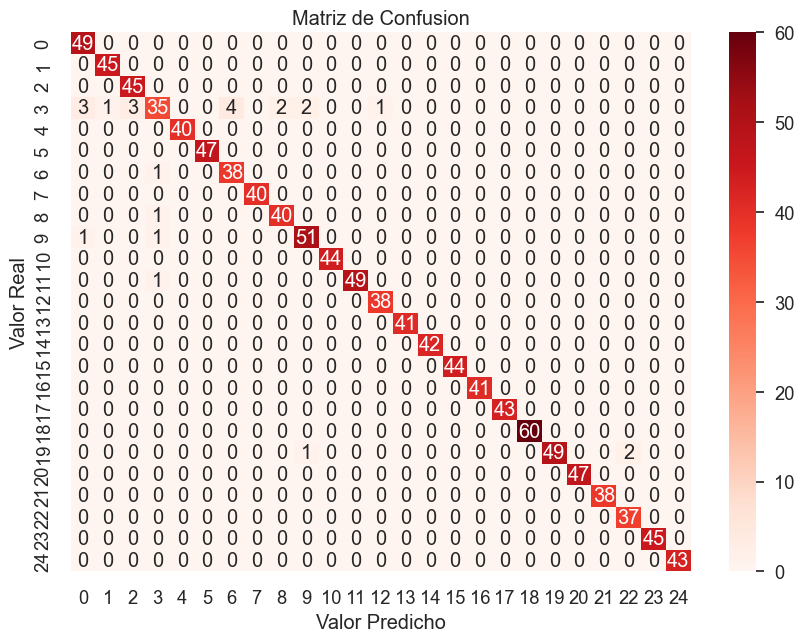

In [29]:
conf_matrix = confusion_matrix(y_test, predict)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds')

plt.xlabel('Valor Predicho')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusion')

plt.show()

### Hago un grafico de las predicciones de mi modelo vs los valores reales para ver cuanto se alejan los valores

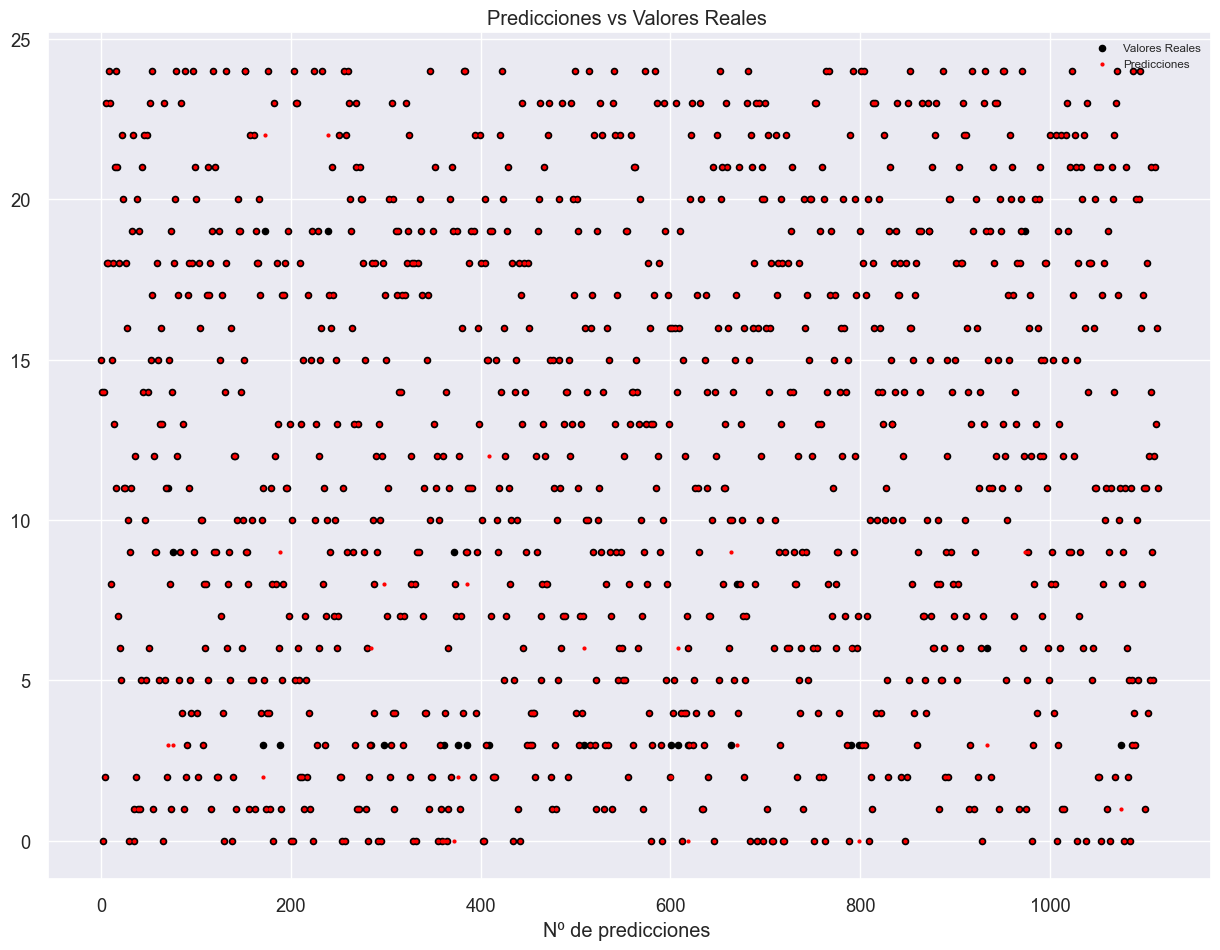

In [30]:
plt.figure(figsize=(15, 11))
plt.scatter(range(len(y_test)), y_test, s=20, alpha=1, color='black', label='Valores Reales') 
plt.scatter(range(len(predict)), predict, s=4, alpha=1, color='red', label='Predicciones')


plt.xlabel('Nº de predicciones ')
plt.ylabel('')
plt.title('Predicciones vs Valores Reales ')
plt.legend(loc='upper right', fontsize='xx-small')

plt.show()

### Muestro el numero de predicciones correctas, predicciones fallidas y el total de predicciones en el set de test

In [31]:
vals = {'true': 0, 'false': 0}
predict = list(predict)
y_test = list(y_test)

for pred, real in zip(predict, y_test):
    
    if pred == real:
        vals['true'] += 1
    
    else:
        vals['false'] += 1

print(f'Predicciones correctas : {vals["true"]}\nPredicciones Fallidas: {vals["false"]}\nPredicciones Totales: {len(y_test)}')

Predicciones correctas : 1091
Predicciones Fallidas: 24
Predicciones Totales: 1115
